#get the dataset

In [ ]:
!pip install kaggle
!kaggle datasets download -d arnavjain1/glaucoma-datasets
!unzip glaucoma-datasets.zip -d /content/gloucoma-datasets

Streaming output truncated to the last 5000 lines.
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0207.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0208.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0209.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0210.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0211.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0212.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0213.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0214.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0215.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0216.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0217.png  
  inflating: /content/gloucoma-datasets/REFUGE/test/Masks_Cropped/T0218.png  
  inflating: 

### copy dataset to Google Drive - **DO NOT run it**

In [ ]:
#copy dataset to Google Drive
!mkdir -p /content/drive/MyDrive/glaucoma-datasets
!cp -d /content/gloucoma-datasets/ORIGA /content/drive/MyDrive/glaucoma-datasets/.

cp: -r not specified; omitting directory '/content/gloucoma-datasets/ORIGA'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# main

In [ ]:
!pip install -U albumentations
!pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.9/269.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 37.9 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

In [ ]:
dataset_dir = '/content/gloucoma-datasets/ORIGA'
#dataset_dir = '/content/drive/MyDrive/glaucoma-datasets/ORIGA'
image_dir = os.path.join(dataset_dir, 'Images_Cropped')
labels_csv = os.path.join(dataset_dir, 'OrigaList.csv')

In [ ]:
labels_df = pd.read_csv(labels_csv)
labels_df.drop(columns=['Eye', 'Set'], axis=1, inplace=True)
labels_df.columns=['Image_name', 'cdr', 'Label']

In [ ]:
labels_df

,Image_name,cdr,Label
0,001.jpg,0.7097,0
1,002.jpg,0.6953,0
2,003.jpg,0.9629,0
3,004.jpg,0.7246,0
4,005.jpg,0.6138,0
...,...,...,...
645,646.jpg,0.6560,1
646,647.jpg,0.7365,1
647,648.jpg,0.5101,1
648,649.jpg,0.5227,0


## visualize dataset

In [ ]:
#DO NOT run this portion
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=0, p=0.5)
])

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.GaussianBlur(p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5)
])



def preprocessing(image_path, augment=True):
    # Load and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(image)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    enhanced_image = cv2.merge(clahe_channels)

    # Convert to float
    enhanced_image = enhanced_image.astype(np.float32) / 255.0

    # Apply augmentations if requested
    if augment:
        augmented = augmentations(image=enhanced_image)
        enhanced_image = augmented["image"]

    return enhanced_image

In [ ]:
labels_df

,Image_name,cdr,Label
0,001.jpg,0.7097,0
1,002.jpg,0.6953,0
2,003.jpg,0.9629,0
3,004.jpg,0.7246,0
4,005.jpg,0.6138,0
...,...,...,...
645,646.jpg,0.6560,1
646,647.jpg,0.7365,1
647,648.jpg,0.5101,1
648,649.jpg,0.5227,0


0


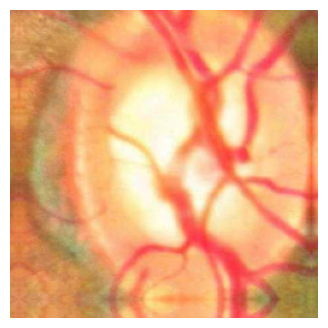

In [ ]:
num = 1
image_path = os.path.join(image_dir, labels_df.loc[num, 'Image_name'])
image = preprocessing(image_path, True)

print (labels_df.loc[num, 'Label'])
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
from transformers import MobileViTModel

mobilevit = MobileViTModel.from_pretrained("apple/mobilevit-small")
print(mobilevit)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

MobileViTModel(
  (conv_stem): MobileViTConvLayer(
    (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): SiLU()
  )
  (encoder): MobileViTEncoder(
    (layer): ModuleList(
      (0): MobileViTMobileNetLayer(
        (layer): ModuleList(
          (0): MobileViTInvertedResidual(
            (expand_1x1): MobileViTConvLayer(
              (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activation): SiLU()
            )
            (conv_3x3): MobileViTConvLayer(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

## fourth try

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import MobileViTModel, MobileViTConfig, get_linear_schedule_with_warmup

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.GaussianBlur(p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), p=0.5),
    A.Resize(height=256, width=256, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


val_transforms = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [ ]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['Image_name']
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        cdr = torch.tensor(self.df.iloc[idx]['cdr'] / 1.0, dtype=torch.float)
        label = torch.tensor(self.df.iloc[idx]['Label'], dtype=torch.long)

        return image, cdr, label

In [ ]:
class MobileViTGlaucomaClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(MobileViTGlaucomaClassifier, self).__init__()
        self.mobilevit = MobileViTModel.from_pretrained("apple/mobilevit-small")

        for param in self.mobilevit.parameters():
            param.requires_grad = False
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.3)

        self.classifier = nn.Sequential(
            nn.Linear(640 + 1, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )

    def unfreeze_last_layer(self):
        """unfreeze the last MobileViT layer and the final convolution layer"""
        for param in self.mobilevit.encoder.layer[4].parameters():
            param.requires_grad = True

        for param in self.mobilevit.conv_1x1_exp.parameters():
            param.requires_grad = True

    def forward(self, image, cdr):
        outputs = self.mobilevit(image)
        pooled_output = self.global_avg_pool(outputs.last_hidden_state)
        pooled_output = pooled_output.view(pooled_output.size(0), -1)
        combined = torch.cat((pooled_output, cdr.unsqueeze(1)), dim=1)

        out = self.dropout(combined)
        out = self.classifier(out)

        return out

In [ ]:
# model = MobileViTGlaucomaClassifier(num_classes=2).to(device)
# print (model)

MobileViTGlaucomaClassifier(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (normal

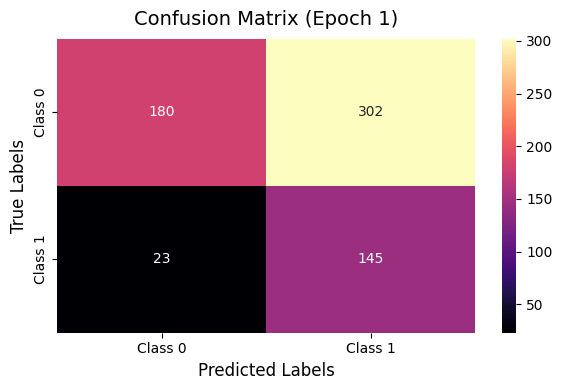

Epoch 1/100, Train Loss: 0.6893, Val Loss: 0.6820, Val Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.37      0.53       482
           1       0.32      0.86      0.47       168

    accuracy                           0.50       650
   macro avg       0.61      0.62      0.50       650
weighted avg       0.74      0.50      0.51       650

ROC AUC Score: 0.7043


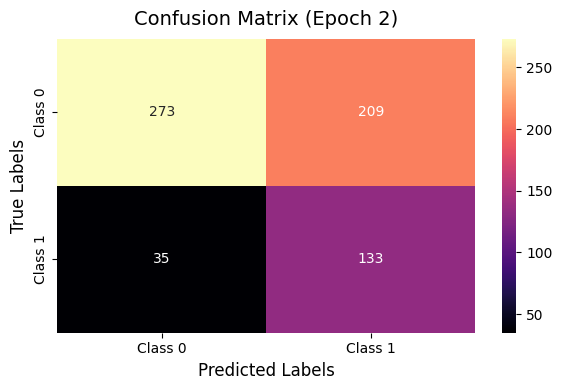

Epoch 2/100, Train Loss: 0.6857, Val Loss: 0.6663, Val Accuracy: 0.6246
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.57      0.69       482
           1       0.39      0.79      0.52       168

    accuracy                           0.62       650
   macro avg       0.64      0.68      0.61       650
weighted avg       0.76      0.62      0.65       650

ROC AUC Score: 0.7459


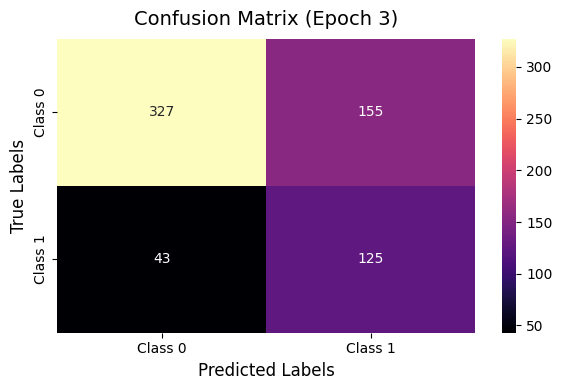

Epoch 3/100, Train Loss: 0.6675, Val Loss: 0.6449, Val Accuracy: 0.6954
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       482
           1       0.45      0.74      0.56       168

    accuracy                           0.70       650
   macro avg       0.67      0.71      0.66       650
weighted avg       0.77      0.70      0.71       650

ROC AUC Score: 0.7759


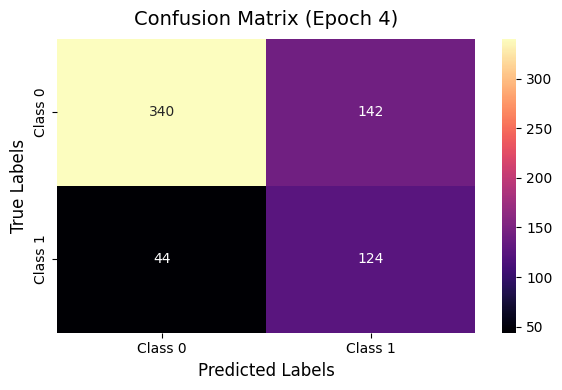

Epoch 4/100, Train Loss: 0.6633, Val Loss: 0.6174, Val Accuracy: 0.7138
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       482
           1       0.47      0.74      0.57       168

    accuracy                           0.71       650
   macro avg       0.68      0.72      0.68       650
weighted avg       0.78      0.71      0.73       650

ROC AUC Score: 0.7848


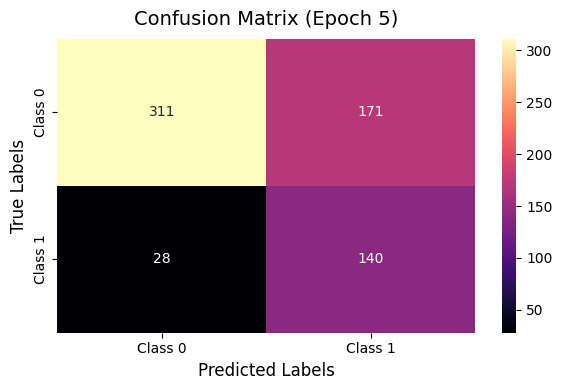

Epoch 5/100, Train Loss: 0.6472, Val Loss: 0.5914, Val Accuracy: 0.6938
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       482
           1       0.45      0.83      0.58       168

    accuracy                           0.69       650
   macro avg       0.68      0.74      0.67       650
weighted avg       0.80      0.69      0.71       650

ROC AUC Score: 0.7992


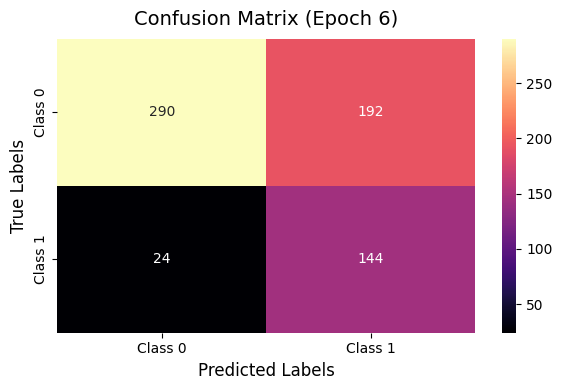

Epoch 6/100, Train Loss: 0.6213, Val Loss: 0.5628, Val Accuracy: 0.6677
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       482
           1       0.43      0.86      0.57       168

    accuracy                           0.67       650
   macro avg       0.68      0.73      0.65       650
weighted avg       0.80      0.67      0.69       650

ROC AUC Score: 0.8023


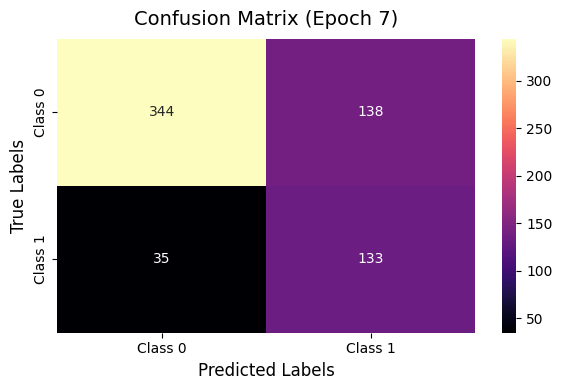

Epoch 7/100, Train Loss: 0.5830, Val Loss: 0.5159, Val Accuracy: 0.7338
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       482
           1       0.49      0.79      0.61       168

    accuracy                           0.73       650
   macro avg       0.70      0.75      0.70       650
weighted avg       0.80      0.73      0.75       650

ROC AUC Score: 0.8198


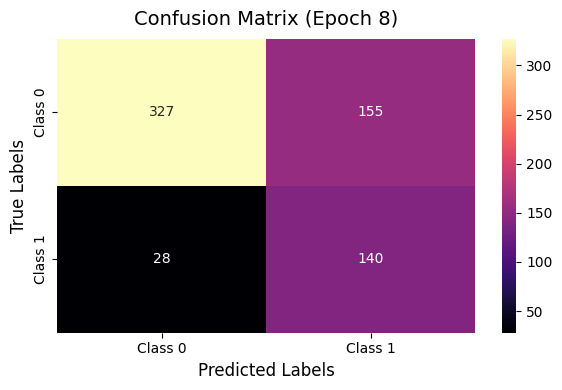

Epoch 8/100, Train Loss: 0.6043, Val Loss: 0.5093, Val Accuracy: 0.7185
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       482
           1       0.47      0.83      0.60       168

    accuracy                           0.72       650
   macro avg       0.70      0.76      0.69       650
weighted avg       0.81      0.72      0.74       650

ROC AUC Score: 0.8312


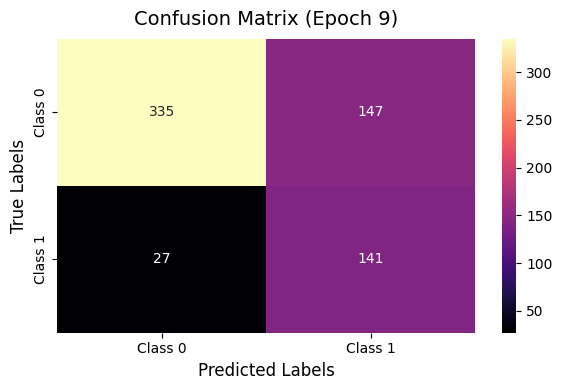

Epoch 9/100, Train Loss: 0.5698, Val Loss: 0.4948, Val Accuracy: 0.7323
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.70      0.79       482
           1       0.49      0.84      0.62       168

    accuracy                           0.73       650
   macro avg       0.71      0.77      0.71       650
weighted avg       0.81      0.73      0.75       650

ROC AUC Score: 0.8438


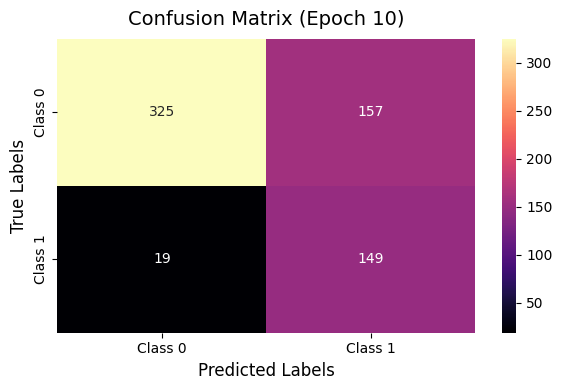

Epoch 10/100, Train Loss: 0.5498, Val Loss: 0.4769, Val Accuracy: 0.7292
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.67      0.79       482
           1       0.49      0.89      0.63       168

    accuracy                           0.73       650
   macro avg       0.72      0.78      0.71       650
weighted avg       0.83      0.73      0.75       650

ROC AUC Score: 0.8543


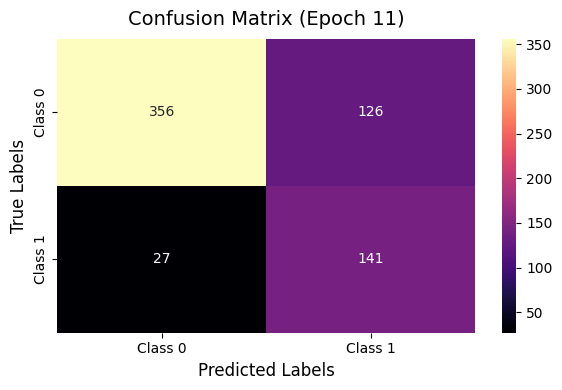

Epoch 11/100, Train Loss: 0.5351, Val Loss: 0.4616, Val Accuracy: 0.7646
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82       482
           1       0.53      0.84      0.65       168

    accuracy                           0.76       650
   macro avg       0.73      0.79      0.74       650
weighted avg       0.83      0.76      0.78       650

ROC AUC Score: 0.8590


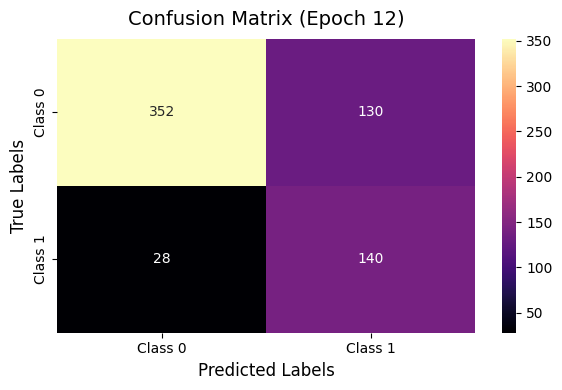

Epoch 12/100, Train Loss: 0.5279, Val Loss: 0.4450, Val Accuracy: 0.7569
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       482
           1       0.52      0.83      0.64       168

    accuracy                           0.76       650
   macro avg       0.72      0.78      0.73       650
weighted avg       0.82      0.76      0.77       650

ROC AUC Score: 0.8693


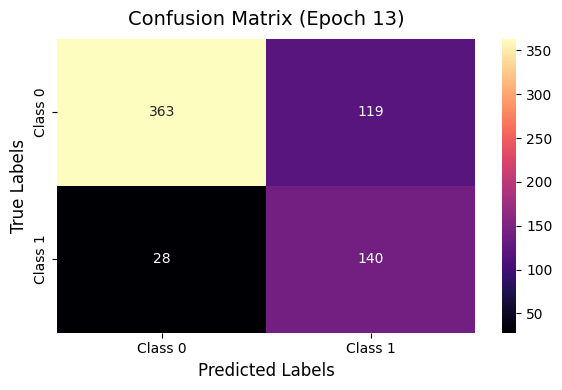

Epoch 13/100, Train Loss: 0.5290, Val Loss: 0.4368, Val Accuracy: 0.7738
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       482
           1       0.54      0.83      0.66       168

    accuracy                           0.77       650
   macro avg       0.73      0.79      0.74       650
weighted avg       0.83      0.77      0.79       650

ROC AUC Score: 0.8719


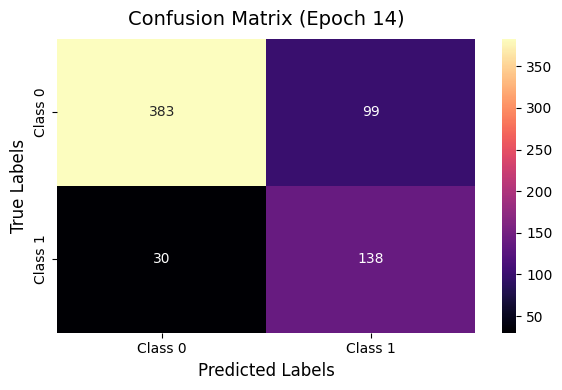

Epoch 14/100, Train Loss: 0.5486, Val Loss: 0.4287, Val Accuracy: 0.8015
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       482
           1       0.58      0.82      0.68       168

    accuracy                           0.80       650
   macro avg       0.75      0.81      0.77       650
weighted avg       0.84      0.80      0.81       650

ROC AUC Score: 0.8770


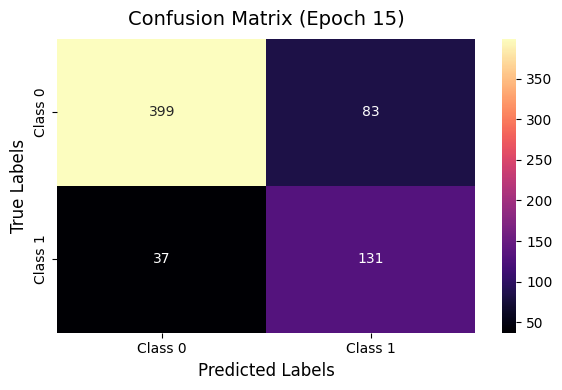

Epoch 15/100, Train Loss: 0.5207, Val Loss: 0.4176, Val Accuracy: 0.8154
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       482
           1       0.61      0.78      0.69       168

    accuracy                           0.82       650
   macro avg       0.76      0.80      0.78       650
weighted avg       0.84      0.82      0.82       650

ROC AUC Score: 0.8882


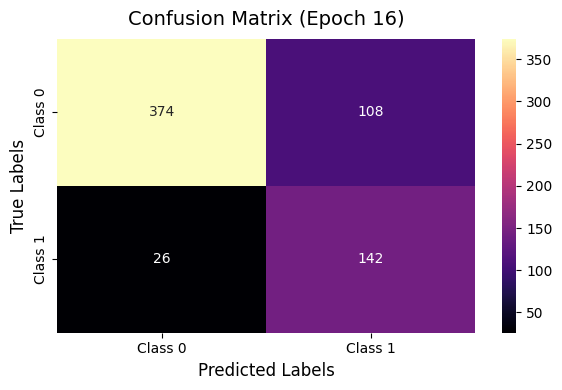

Epoch 16/100, Train Loss: 0.5021, Val Loss: 0.4089, Val Accuracy: 0.7938
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       482
           1       0.57      0.85      0.68       168

    accuracy                           0.79       650
   macro avg       0.75      0.81      0.76       650
weighted avg       0.84      0.79      0.80       650

ROC AUC Score: 0.8901


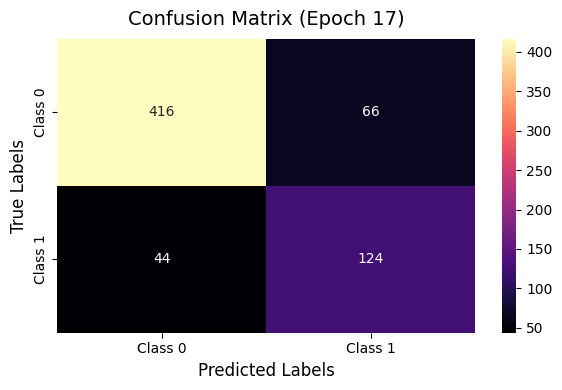

Epoch 17/100, Train Loss: 0.5273, Val Loss: 0.4289, Val Accuracy: 0.8308
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       482
           1       0.65      0.74      0.69       168

    accuracy                           0.83       650
   macro avg       0.78      0.80      0.79       650
weighted avg       0.84      0.83      0.83       650

ROC AUC Score: 0.8920


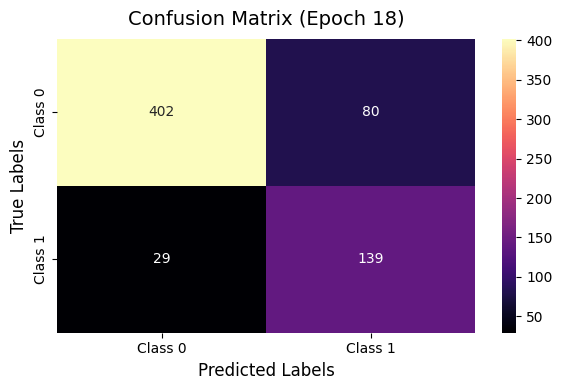

Epoch 18/100, Train Loss: 0.5036, Val Loss: 0.3898, Val Accuracy: 0.8323
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       482
           1       0.63      0.83      0.72       168

    accuracy                           0.83       650
   macro avg       0.78      0.83      0.80       650
weighted avg       0.86      0.83      0.84       650

ROC AUC Score: 0.9032


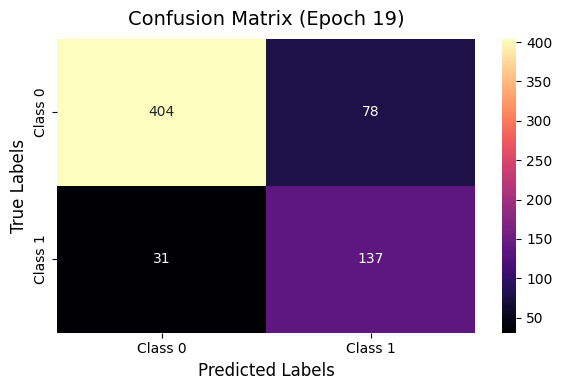

Epoch 19/100, Train Loss: 0.5002, Val Loss: 0.3776, Val Accuracy: 0.8323
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       482
           1       0.64      0.82      0.72       168

    accuracy                           0.83       650
   macro avg       0.78      0.83      0.80       650
weighted avg       0.85      0.83      0.84       650

ROC AUC Score: 0.9067


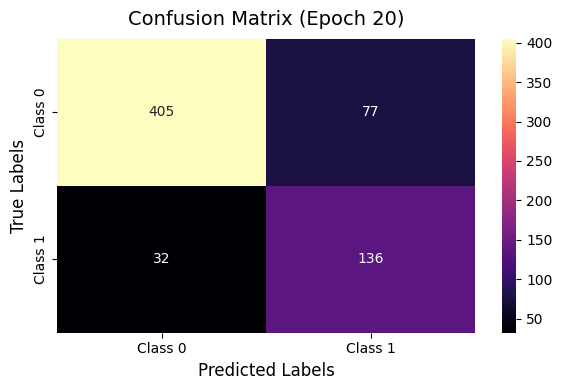

Epoch 20/100, Train Loss: 0.4743, Val Loss: 0.3759, Val Accuracy: 0.8323
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       482
           1       0.64      0.81      0.71       168

    accuracy                           0.83       650
   macro avg       0.78      0.82      0.80       650
weighted avg       0.85      0.83      0.84       650

ROC AUC Score: 0.9098


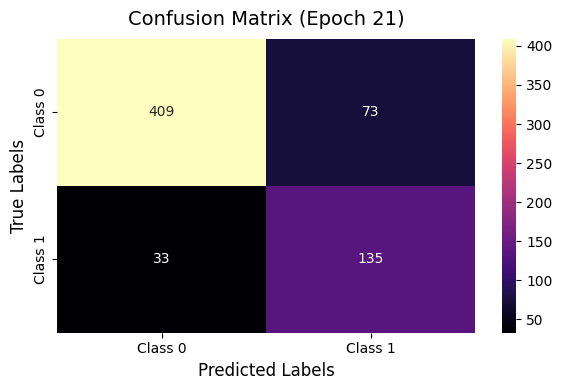

Epoch 21/100, Train Loss: 0.4939, Val Loss: 0.3813, Val Accuracy: 0.8369
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       482
           1       0.65      0.80      0.72       168

    accuracy                           0.84       650
   macro avg       0.79      0.83      0.80       650
weighted avg       0.85      0.84      0.84       650

ROC AUC Score: 0.9108


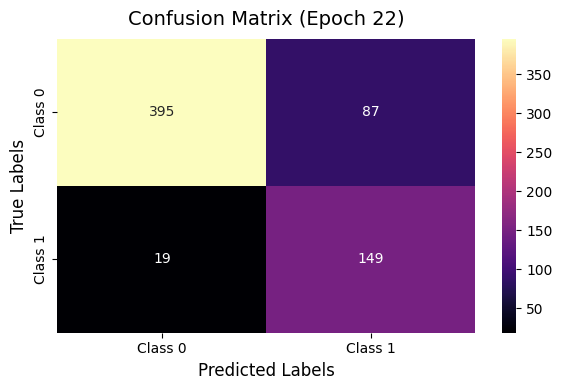

Epoch 22/100, Train Loss: 0.4696, Val Loss: 0.3623, Val Accuracy: 0.8369
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       482
           1       0.63      0.89      0.74       168

    accuracy                           0.84       650
   macro avg       0.79      0.85      0.81       650
weighted avg       0.87      0.84      0.84       650

ROC AUC Score: 0.9135


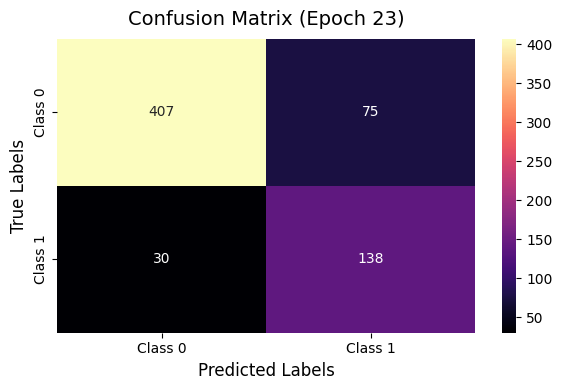

Epoch 23/100, Train Loss: 0.4600, Val Loss: 0.3624, Val Accuracy: 0.8385
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       482
           1       0.65      0.82      0.72       168

    accuracy                           0.84       650
   macro avg       0.79      0.83      0.81       650
weighted avg       0.86      0.84      0.84       650

ROC AUC Score: 0.9175


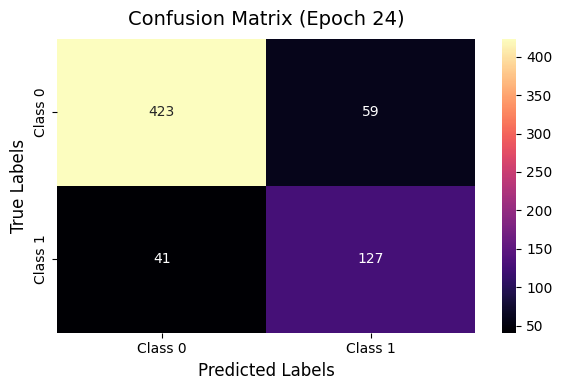

Epoch 24/100, Train Loss: 0.4544, Val Loss: 0.3902, Val Accuracy: 0.8462
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       482
           1       0.68      0.76      0.72       168

    accuracy                           0.85       650
   macro avg       0.80      0.82      0.81       650
weighted avg       0.85      0.85      0.85       650

ROC AUC Score: 0.9181


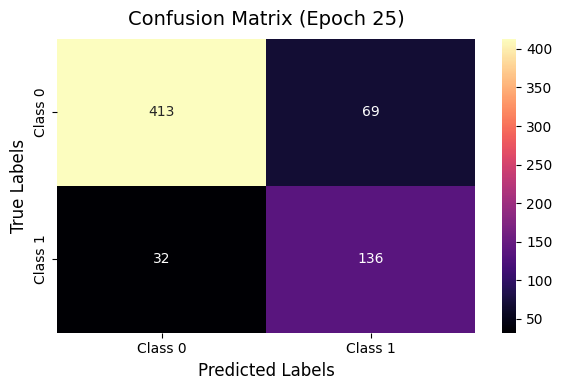

Epoch 25/100, Train Loss: 0.4479, Val Loss: 0.3555, Val Accuracy: 0.8446
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       482
           1       0.66      0.81      0.73       168

    accuracy                           0.84       650
   macro avg       0.80      0.83      0.81       650
weighted avg       0.86      0.84      0.85       650

ROC AUC Score: 0.9234


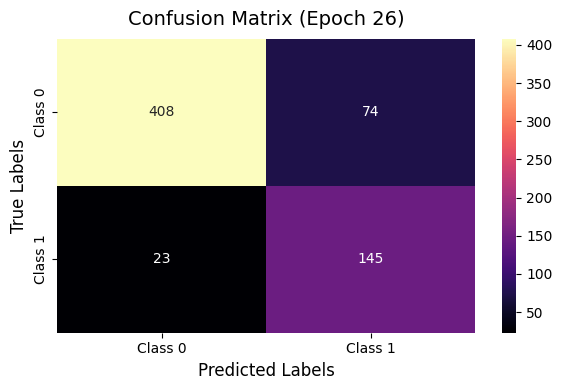

Epoch 26/100, Train Loss: 0.4486, Val Loss: 0.3377, Val Accuracy: 0.8508
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       482
           1       0.66      0.86      0.75       168

    accuracy                           0.85       650
   macro avg       0.80      0.85      0.82       650
weighted avg       0.87      0.85      0.86       650

ROC AUC Score: 0.9257


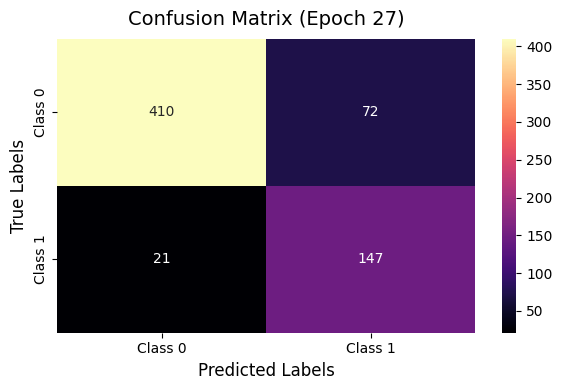

Epoch 27/100, Train Loss: 0.4695, Val Loss: 0.3341, Val Accuracy: 0.8569
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       482
           1       0.67      0.88      0.76       168

    accuracy                           0.86       650
   macro avg       0.81      0.86      0.83       650
weighted avg       0.88      0.86      0.86       650

ROC AUC Score: 0.9284


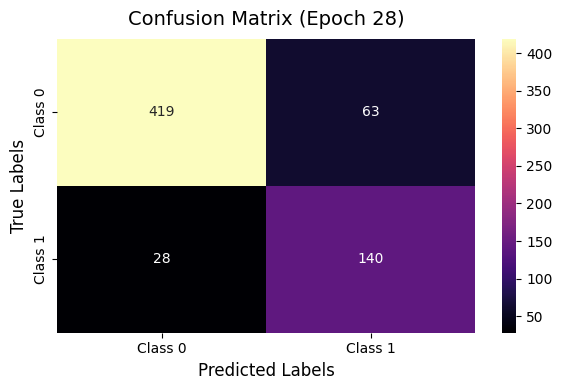

Epoch 28/100, Train Loss: 0.4677, Val Loss: 0.3392, Val Accuracy: 0.8600
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       482
           1       0.69      0.83      0.75       168

    accuracy                           0.86       650
   macro avg       0.81      0.85      0.83       650
weighted avg       0.87      0.86      0.86       650

ROC AUC Score: 0.9309


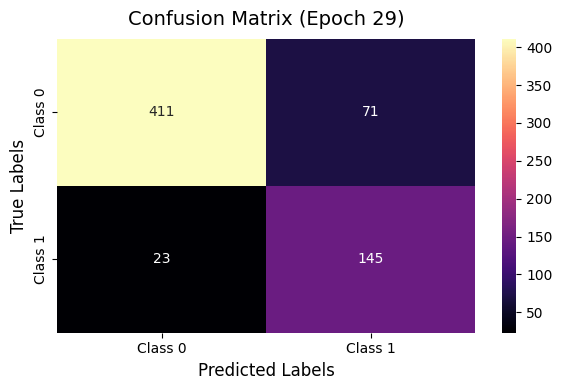

Epoch 29/100, Train Loss: 0.4530, Val Loss: 0.3275, Val Accuracy: 0.8554
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       482
           1       0.67      0.86      0.76       168

    accuracy                           0.86       650
   macro avg       0.81      0.86      0.83       650
weighted avg       0.88      0.86      0.86       650

ROC AUC Score: 0.9318


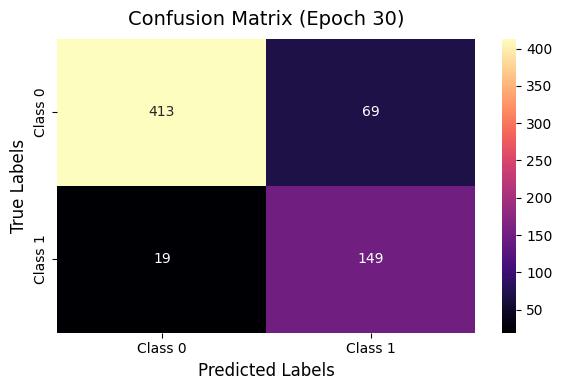

Epoch 30/100, Train Loss: 0.4503, Val Loss: 0.3163, Val Accuracy: 0.8646
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.86      0.90       482
           1       0.68      0.89      0.77       168

    accuracy                           0.86       650
   macro avg       0.82      0.87      0.84       650
weighted avg       0.89      0.86      0.87       650

ROC AUC Score: 0.9357


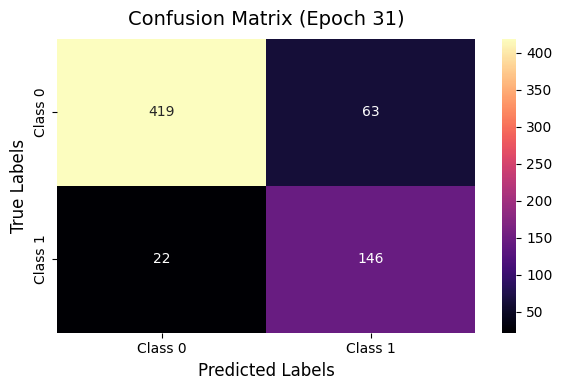

Epoch 31/100, Train Loss: 0.4539, Val Loss: 0.3153, Val Accuracy: 0.8692
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       482
           1       0.70      0.87      0.77       168

    accuracy                           0.87       650
   macro avg       0.82      0.87      0.84       650
weighted avg       0.89      0.87      0.87       650

ROC AUC Score: 0.9382


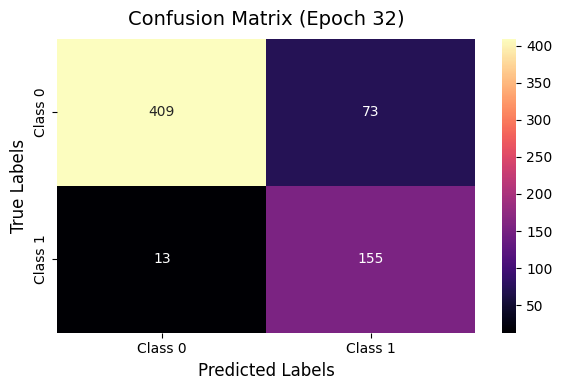

Epoch 32/100, Train Loss: 0.4390, Val Loss: 0.2962, Val Accuracy: 0.8677
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90       482
           1       0.68      0.92      0.78       168

    accuracy                           0.87       650
   macro avg       0.82      0.89      0.84       650
weighted avg       0.89      0.87      0.87       650

ROC AUC Score: 0.9429


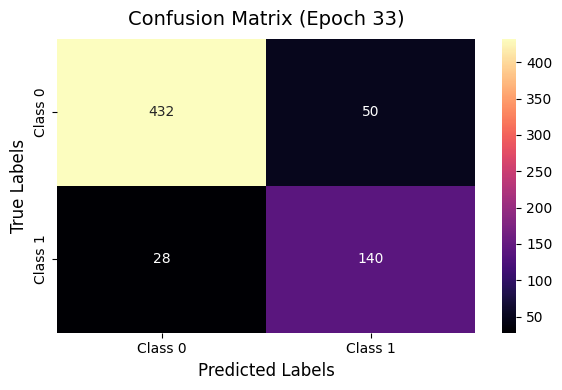

Epoch 33/100, Train Loss: 0.4424, Val Loss: 0.3217, Val Accuracy: 0.8800
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       482
           1       0.74      0.83      0.78       168

    accuracy                           0.88       650
   macro avg       0.84      0.86      0.85       650
weighted avg       0.89      0.88      0.88       650

ROC AUC Score: 0.9429


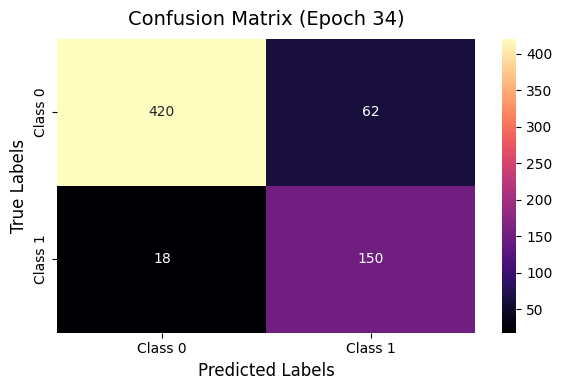

Epoch 34/100, Train Loss: 0.4673, Val Loss: 0.2964, Val Accuracy: 0.8769
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       482
           1       0.71      0.89      0.79       168

    accuracy                           0.88       650
   macro avg       0.83      0.88      0.85       650
weighted avg       0.89      0.88      0.88       650

ROC AUC Score: 0.9449


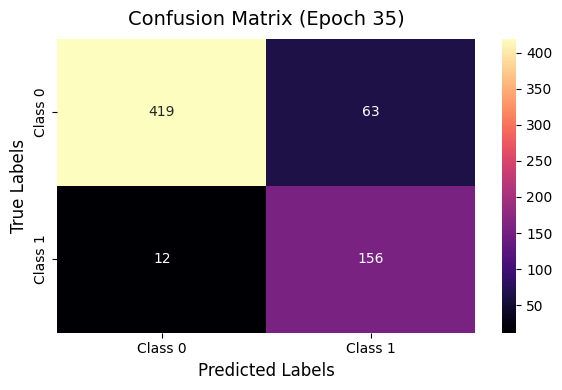

Epoch 35/100, Train Loss: 0.4565, Val Loss: 0.2789, Val Accuracy: 0.8846
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       482
           1       0.71      0.93      0.81       168

    accuracy                           0.88       650
   macro avg       0.84      0.90      0.86       650
weighted avg       0.91      0.88      0.89       650

ROC AUC Score: 0.9494


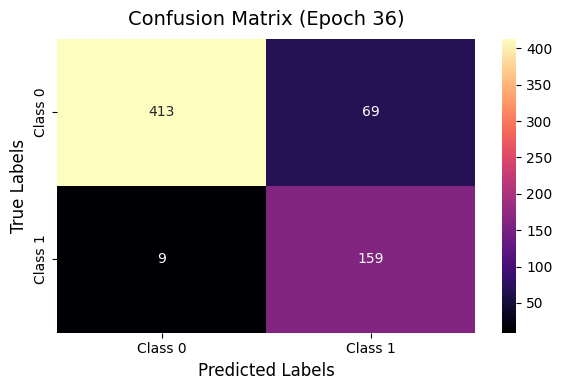

Epoch 36/100, Train Loss: 0.4297, Val Loss: 0.2778, Val Accuracy: 0.8800
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       482
           1       0.70      0.95      0.80       168

    accuracy                           0.88       650
   macro avg       0.84      0.90      0.86       650
weighted avg       0.91      0.88      0.89       650

ROC AUC Score: 0.9499


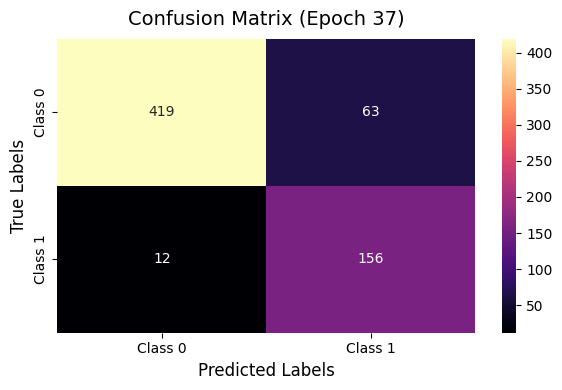

Epoch 37/100, Train Loss: 0.4117, Val Loss: 0.2704, Val Accuracy: 0.8846
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       482
           1       0.71      0.93      0.81       168

    accuracy                           0.88       650
   macro avg       0.84      0.90      0.86       650
weighted avg       0.91      0.88      0.89       650

ROC AUC Score: 0.9520


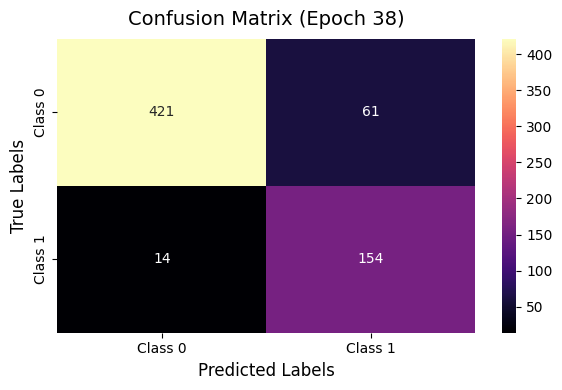

Epoch 38/100, Train Loss: 0.4109, Val Loss: 0.2659, Val Accuracy: 0.8846
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       482
           1       0.72      0.92      0.80       168

    accuracy                           0.88       650
   macro avg       0.84      0.90      0.86       650
weighted avg       0.90      0.88      0.89       650

ROC AUC Score: 0.9526


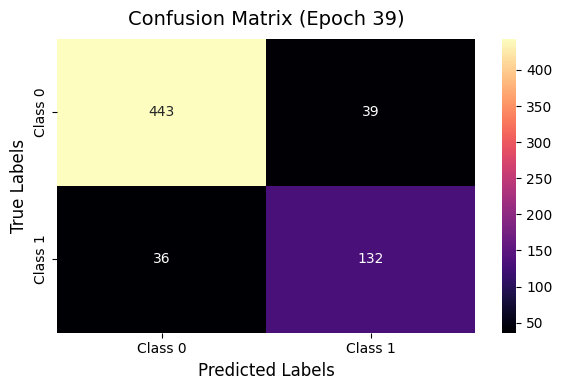

Epoch 39/100, Train Loss: 0.4302, Val Loss: 0.3157, Val Accuracy: 0.8846
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       482
           1       0.77      0.79      0.78       168

    accuracy                           0.88       650
   macro avg       0.85      0.85      0.85       650
weighted avg       0.89      0.88      0.88       650

ROC AUC Score: 0.9527


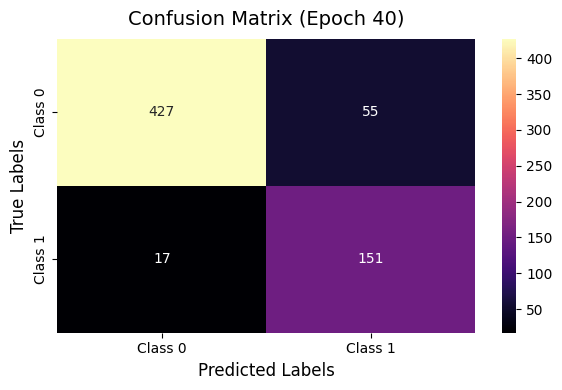

Epoch 40/100, Train Loss: 0.4366, Val Loss: 0.2626, Val Accuracy: 0.8892
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       482
           1       0.73      0.90      0.81       168

    accuracy                           0.89       650
   macro avg       0.85      0.89      0.86       650
weighted avg       0.90      0.89      0.89       650

ROC AUC Score: 0.9603


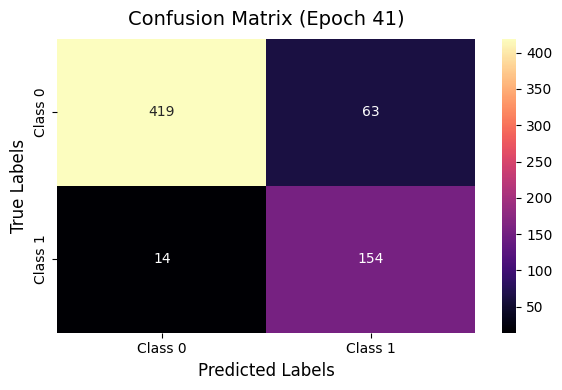

Epoch 41/100, Train Loss: 0.4217, Val Loss: 0.2476, Val Accuracy: 0.8815
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       482
           1       0.71      0.92      0.80       168

    accuracy                           0.88       650
   macro avg       0.84      0.89      0.86       650
weighted avg       0.90      0.88      0.89       650

ROC AUC Score: 0.9619


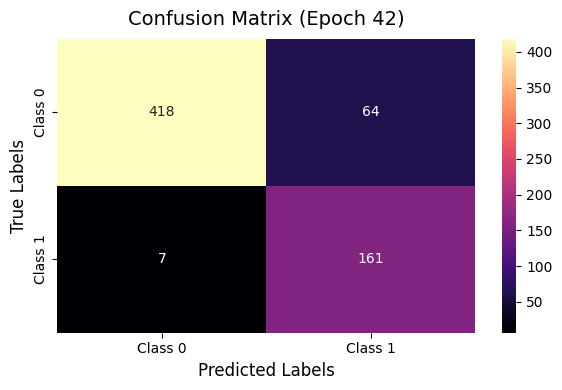

Epoch 42/100, Train Loss: 0.4121, Val Loss: 0.2443, Val Accuracy: 0.8908
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       482
           1       0.72      0.96      0.82       168

    accuracy                           0.89       650
   macro avg       0.85      0.91      0.87       650
weighted avg       0.91      0.89      0.90       650

ROC AUC Score: 0.9624


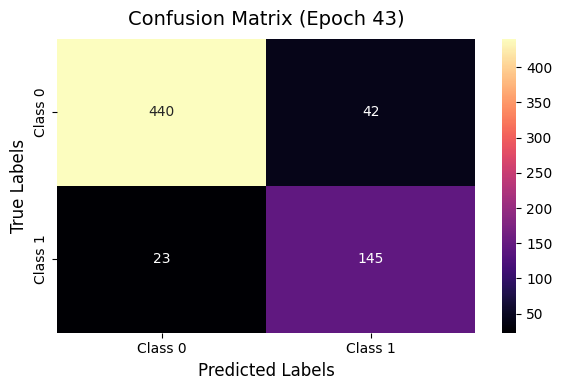

Epoch 43/100, Train Loss: 0.4409, Val Loss: 0.2613, Val Accuracy: 0.9000
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       482
           1       0.78      0.86      0.82       168

    accuracy                           0.90       650
   macro avg       0.86      0.89      0.87       650
weighted avg       0.91      0.90      0.90       650

ROC AUC Score: 0.9641


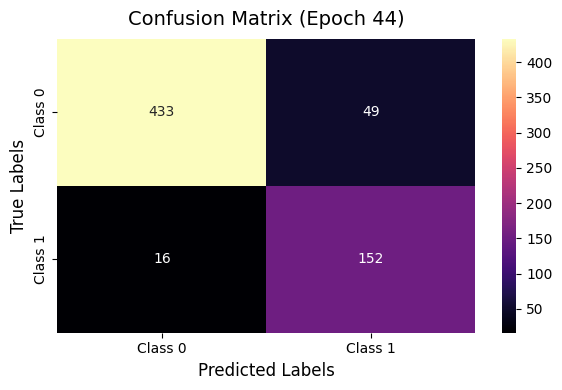

Epoch 44/100, Train Loss: 0.4457, Val Loss: 0.2478, Val Accuracy: 0.9000
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       482
           1       0.76      0.90      0.82       168

    accuracy                           0.90       650
   macro avg       0.86      0.90      0.88       650
weighted avg       0.91      0.90      0.90       650

ROC AUC Score: 0.9627


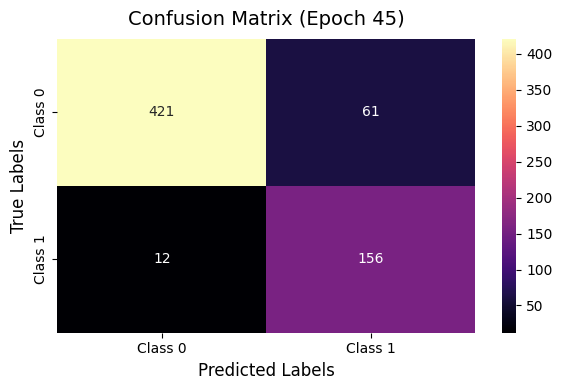

Epoch 45/100, Train Loss: 0.4048, Val Loss: 0.2438, Val Accuracy: 0.8877
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       482
           1       0.72      0.93      0.81       168

    accuracy                           0.89       650
   macro avg       0.85      0.90      0.87       650
weighted avg       0.91      0.89      0.89       650

ROC AUC Score: 0.9629


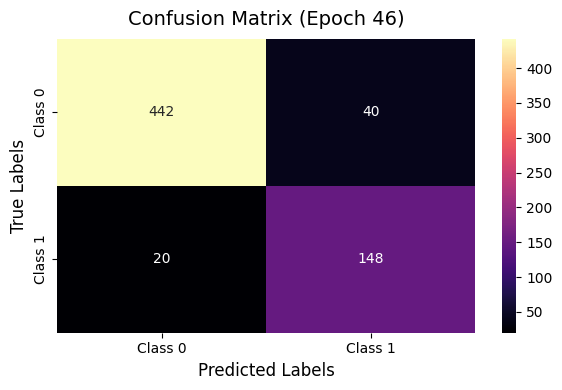

Epoch 46/100, Train Loss: 0.3862, Val Loss: 0.2564, Val Accuracy: 0.9077
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       482
           1       0.79      0.88      0.83       168

    accuracy                           0.91       650
   macro avg       0.87      0.90      0.88       650
weighted avg       0.91      0.91      0.91       650

ROC AUC Score: 0.9656


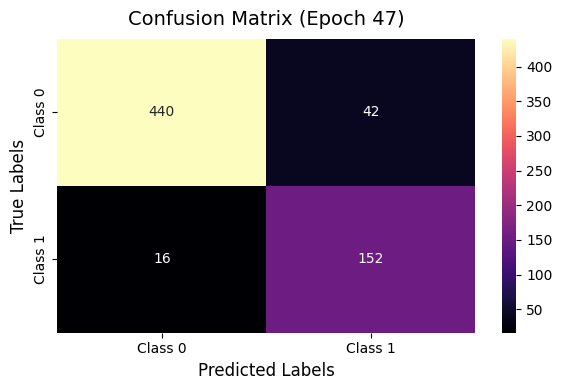

Epoch 47/100, Train Loss: 0.3957, Val Loss: 0.2400, Val Accuracy: 0.9108
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       482
           1       0.78      0.90      0.84       168

    accuracy                           0.91       650
   macro avg       0.87      0.91      0.89       650
weighted avg       0.92      0.91      0.91       650

ROC AUC Score: 0.9680


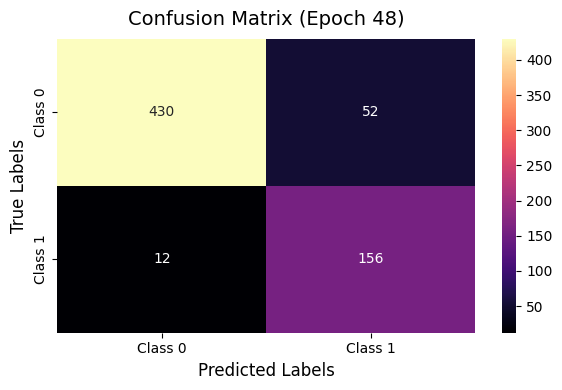

Epoch 48/100, Train Loss: 0.3619, Val Loss: 0.2265, Val Accuracy: 0.9015
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       482
           1       0.75      0.93      0.83       168

    accuracy                           0.90       650
   macro avg       0.86      0.91      0.88       650
weighted avg       0.92      0.90      0.90       650

ROC AUC Score: 0.9692


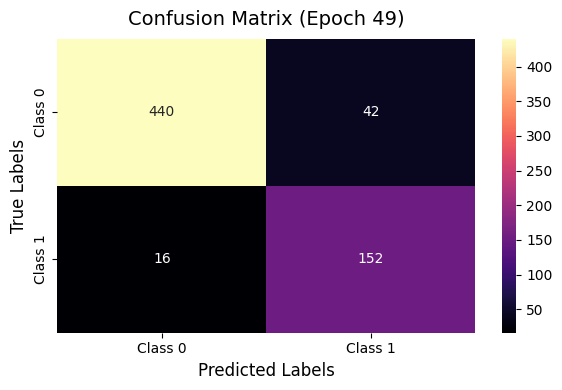

Epoch 49/100, Train Loss: 0.3672, Val Loss: 0.2238, Val Accuracy: 0.9108
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       482
           1       0.78      0.90      0.84       168

    accuracy                           0.91       650
   macro avg       0.87      0.91      0.89       650
weighted avg       0.92      0.91      0.91       650

ROC AUC Score: 0.9713


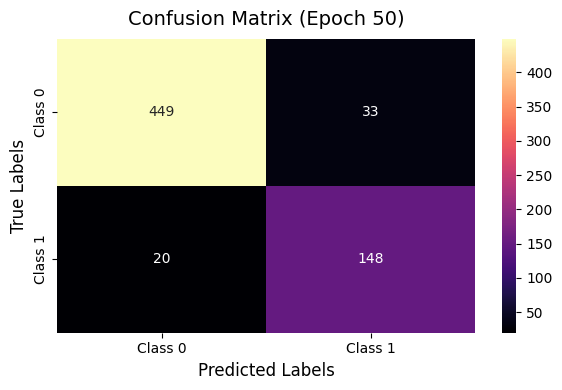

Epoch 50/100, Train Loss: 0.4033, Val Loss: 0.2200, Val Accuracy: 0.9185
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       482
           1       0.82      0.88      0.85       168

    accuracy                           0.92       650
   macro avg       0.89      0.91      0.90       650
weighted avg       0.92      0.92      0.92       650

ROC AUC Score: 0.9734


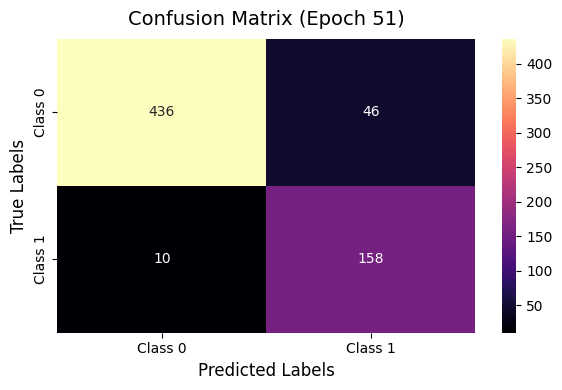

Epoch 51/100, Train Loss: 0.3986, Val Loss: 0.2109, Val Accuracy: 0.9138
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       482
           1       0.77      0.94      0.85       168

    accuracy                           0.91       650
   macro avg       0.88      0.92      0.89       650
weighted avg       0.93      0.91      0.92       650

ROC AUC Score: 0.9729


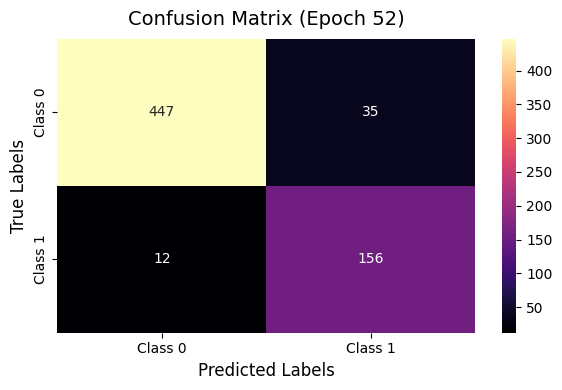

Epoch 52/100, Train Loss: 0.3843, Val Loss: 0.2187, Val Accuracy: 0.9277
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       482
           1       0.82      0.93      0.87       168

    accuracy                           0.93       650
   macro avg       0.90      0.93      0.91       650
weighted avg       0.93      0.93      0.93       650

ROC AUC Score: 0.9759


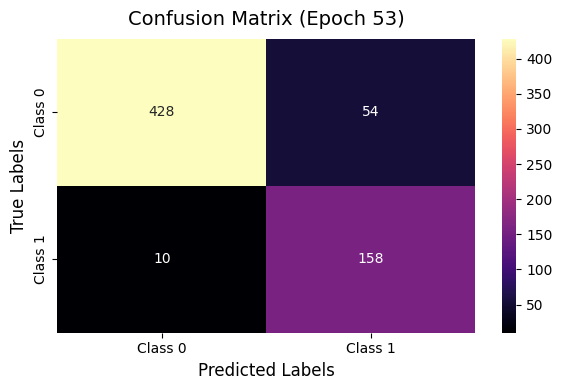

Epoch 53/100, Train Loss: 0.4419, Val Loss: 0.1986, Val Accuracy: 0.9015
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       482
           1       0.75      0.94      0.83       168

    accuracy                           0.90       650
   macro avg       0.86      0.91      0.88       650
weighted avg       0.92      0.90      0.90       650

ROC AUC Score: 0.9737


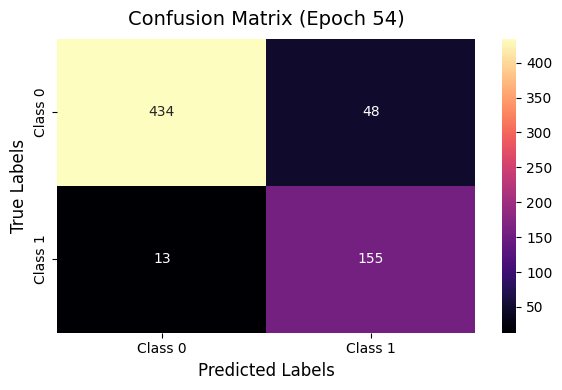

Epoch 54/100, Train Loss: 0.3884, Val Loss: 0.2066, Val Accuracy: 0.9062
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       482
           1       0.76      0.92      0.84       168

    accuracy                           0.91       650
   macro avg       0.87      0.91      0.88       650
weighted avg       0.92      0.91      0.91       650

ROC AUC Score: 0.9737


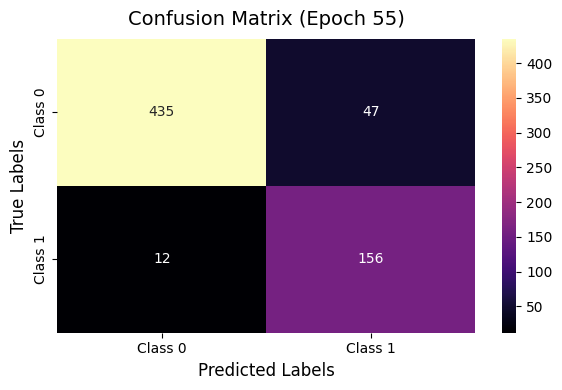

Epoch 55/100, Train Loss: 0.3908, Val Loss: 0.2057, Val Accuracy: 0.9092
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       482
           1       0.77      0.93      0.84       168

    accuracy                           0.91       650
   macro avg       0.87      0.92      0.89       650
weighted avg       0.92      0.91      0.91       650

ROC AUC Score: 0.9730


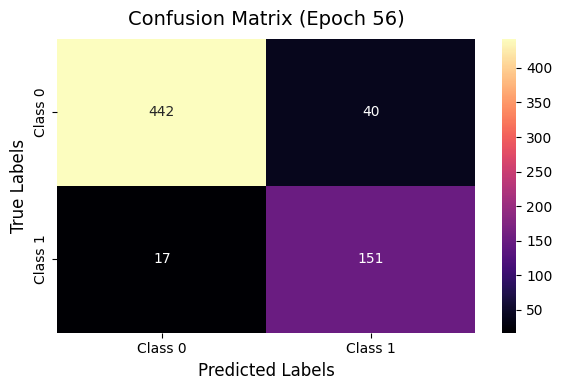

Epoch 56/100, Train Loss: 0.3801, Val Loss: 0.2059, Val Accuracy: 0.9123
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       482
           1       0.79      0.90      0.84       168

    accuracy                           0.91       650
   macro avg       0.88      0.91      0.89       650
weighted avg       0.92      0.91      0.91       650

ROC AUC Score: 0.9759


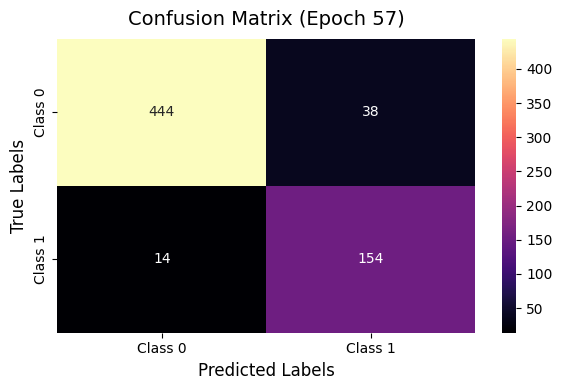

Epoch 57/100, Train Loss: 0.3883, Val Loss: 0.2000, Val Accuracy: 0.9200
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       482
           1       0.80      0.92      0.86       168

    accuracy                           0.92       650
   macro avg       0.89      0.92      0.90       650
weighted avg       0.93      0.92      0.92       650

ROC AUC Score: 0.9770


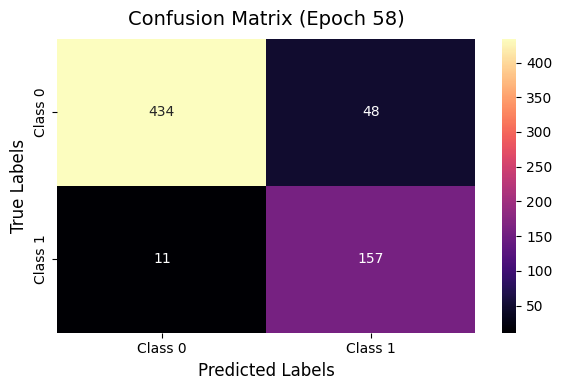

Epoch 58/100, Train Loss: 0.3849, Val Loss: 0.1970, Val Accuracy: 0.9092
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       482
           1       0.77      0.93      0.84       168

    accuracy                           0.91       650
   macro avg       0.87      0.92      0.89       650
weighted avg       0.92      0.91      0.91       650

ROC AUC Score: 0.9777


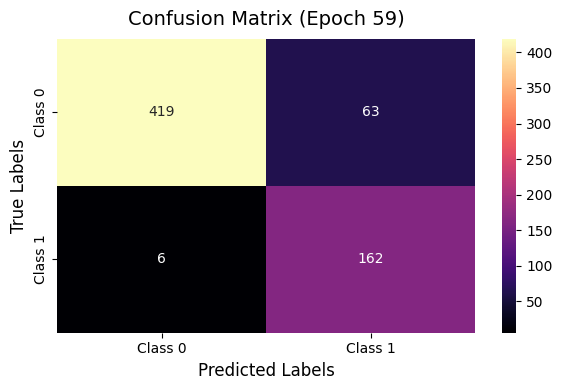

Epoch 59/100, Train Loss: 0.3520, Val Loss: 0.1897, Val Accuracy: 0.8938
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92       482
           1       0.72      0.96      0.82       168

    accuracy                           0.89       650
   macro avg       0.85      0.92      0.87       650
weighted avg       0.92      0.89      0.90       650

ROC AUC Score: 0.9775


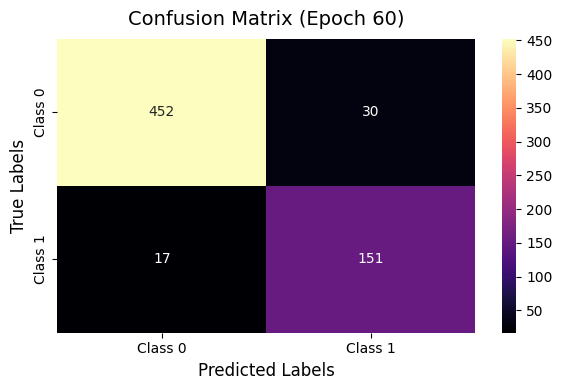

Epoch 60/100, Train Loss: 0.4008, Val Loss: 0.2026, Val Accuracy: 0.9277
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       482
           1       0.83      0.90      0.87       168

    accuracy                           0.93       650
   macro avg       0.90      0.92      0.91       650
weighted avg       0.93      0.93      0.93       650

ROC AUC Score: 0.9781


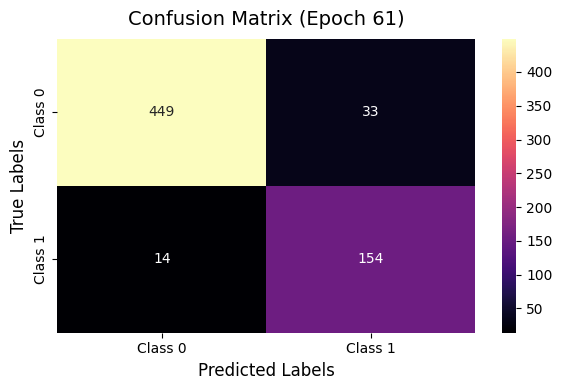

Epoch 61/100, Train Loss: 0.3976, Val Loss: 0.1941, Val Accuracy: 0.9277
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       482
           1       0.82      0.92      0.87       168

    accuracy                           0.93       650
   macro avg       0.90      0.92      0.91       650
weighted avg       0.93      0.93      0.93       650

ROC AUC Score: 0.9810


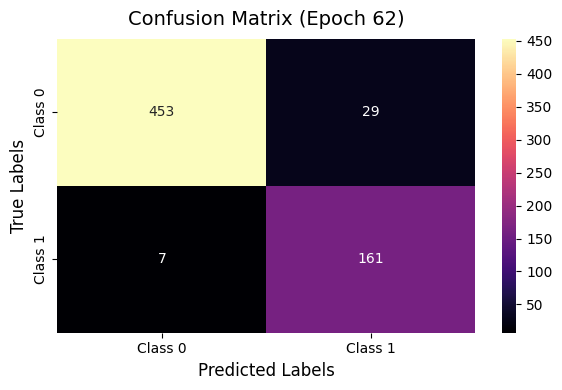

Epoch 62/100, Train Loss: 0.3470, Val Loss: 0.1815, Val Accuracy: 0.9446
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       482
           1       0.85      0.96      0.90       168

    accuracy                           0.94       650
   macro avg       0.92      0.95      0.93       650
weighted avg       0.95      0.94      0.95       650

ROC AUC Score: 0.9831


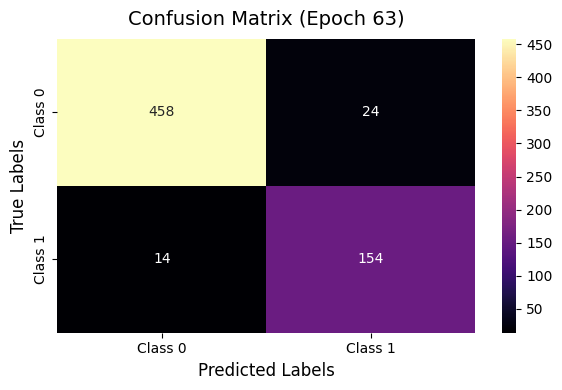

Epoch 63/100, Train Loss: 0.3634, Val Loss: 0.1915, Val Accuracy: 0.9415
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       482
           1       0.87      0.92      0.89       168

    accuracy                           0.94       650
   macro avg       0.92      0.93      0.93       650
weighted avg       0.94      0.94      0.94       650

ROC AUC Score: 0.9823


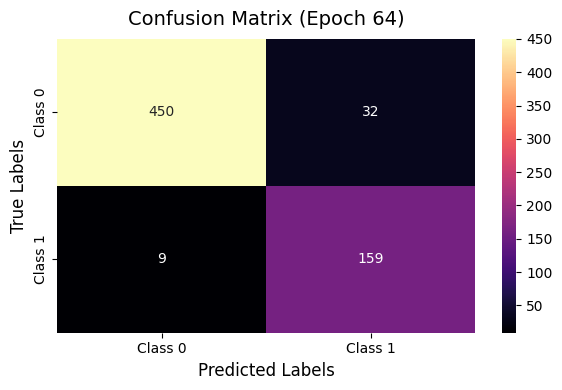

Epoch 64/100, Train Loss: 0.3661, Val Loss: 0.1673, Val Accuracy: 0.9369
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       482
           1       0.83      0.95      0.89       168

    accuracy                           0.94       650
   macro avg       0.91      0.94      0.92       650
weighted avg       0.94      0.94      0.94       650

ROC AUC Score: 0.9858


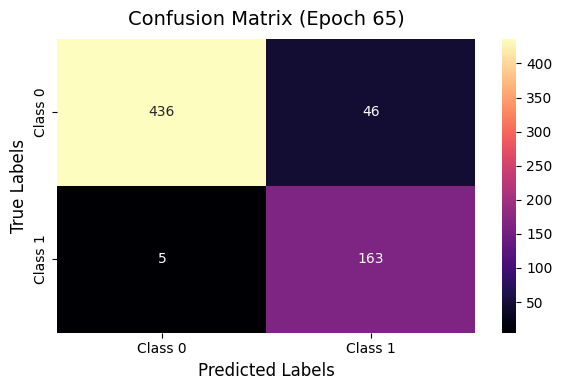

Epoch 65/100, Train Loss: 0.3711, Val Loss: 0.1623, Val Accuracy: 0.9215
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       482
           1       0.78      0.97      0.86       168

    accuracy                           0.92       650
   macro avg       0.88      0.94      0.90       650
weighted avg       0.93      0.92      0.92       650

ROC AUC Score: 0.9839


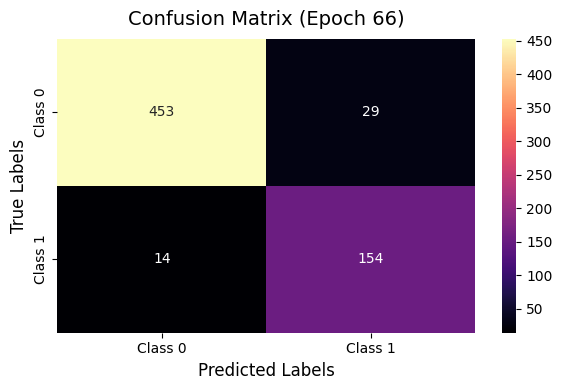

Epoch 66/100, Train Loss: 0.3741, Val Loss: 0.1781, Val Accuracy: 0.9338
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       482
           1       0.84      0.92      0.88       168

    accuracy                           0.93       650
   macro avg       0.91      0.93      0.92       650
weighted avg       0.94      0.93      0.93       650

ROC AUC Score: 0.9847


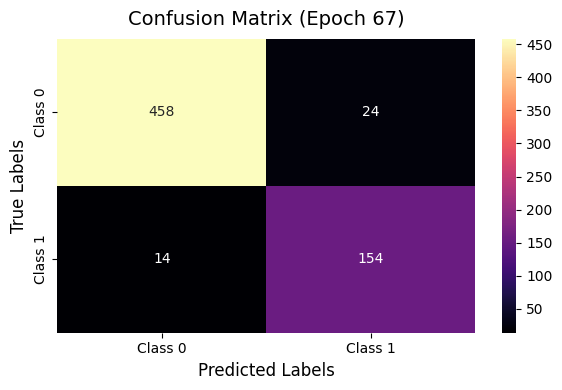

Epoch 67/100, Train Loss: 0.3674, Val Loss: 0.1655, Val Accuracy: 0.9415
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       482
           1       0.87      0.92      0.89       168

    accuracy                           0.94       650
   macro avg       0.92      0.93      0.93       650
weighted avg       0.94      0.94      0.94       650

ROC AUC Score: 0.9856


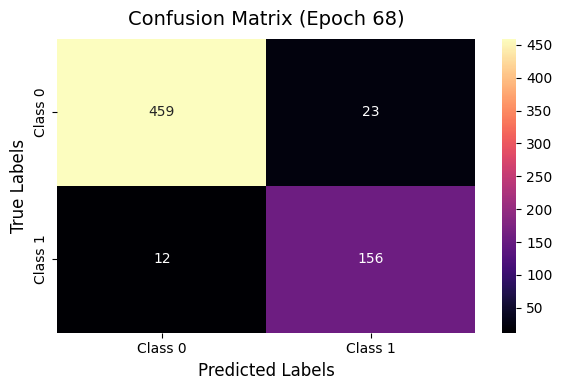

Epoch 68/100, Train Loss: 0.3744, Val Loss: 0.1780, Val Accuracy: 0.9462
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       482
           1       0.87      0.93      0.90       168

    accuracy                           0.95       650
   macro avg       0.92      0.94      0.93       650
weighted avg       0.95      0.95      0.95       650

ROC AUC Score: 0.9833


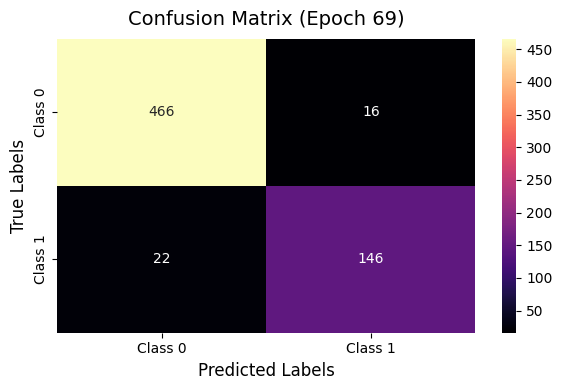

Epoch 69/100, Train Loss: 0.3324, Val Loss: 0.2000, Val Accuracy: 0.9415
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       482
           1       0.90      0.87      0.88       168

    accuracy                           0.94       650
   macro avg       0.93      0.92      0.92       650
weighted avg       0.94      0.94      0.94       650

ROC AUC Score: 0.9808


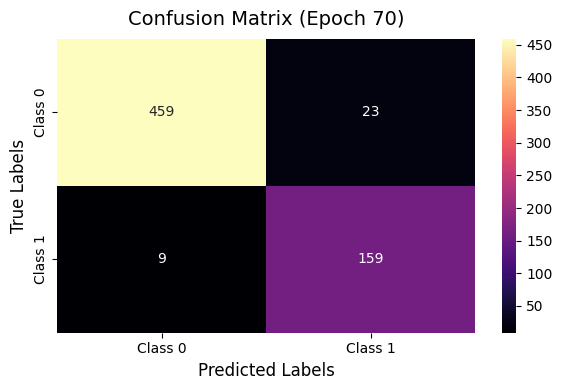

Epoch 70/100, Train Loss: 0.3605, Val Loss: 0.1481, Val Accuracy: 0.9508
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       482
           1       0.87      0.95      0.91       168

    accuracy                           0.95       650
   macro avg       0.93      0.95      0.94       650
weighted avg       0.95      0.95      0.95       650

ROC AUC Score: 0.9883


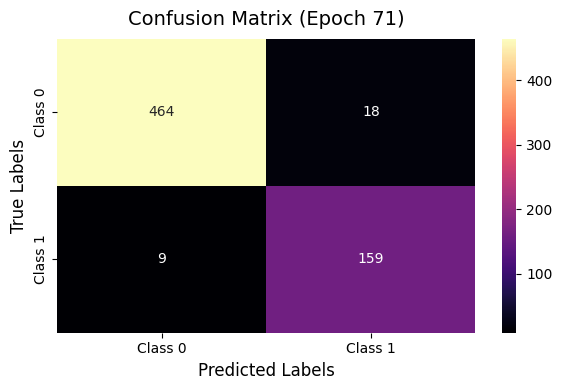

Epoch 71/100, Train Loss: 0.3431, Val Loss: 0.1377, Val Accuracy: 0.9585
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       482
           1       0.90      0.95      0.92       168

    accuracy                           0.96       650
   macro avg       0.94      0.95      0.95       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9892


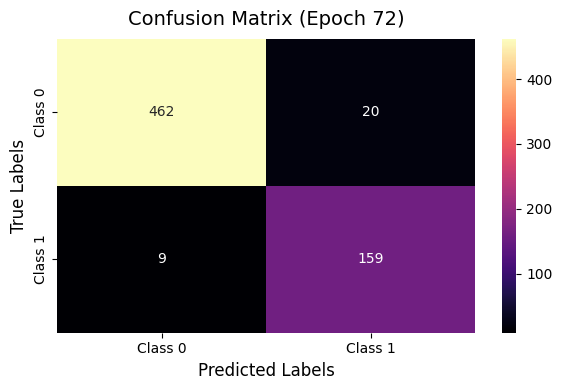

Epoch 72/100, Train Loss: 0.3534, Val Loss: 0.1401, Val Accuracy: 0.9554
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       482
           1       0.89      0.95      0.92       168

    accuracy                           0.96       650
   macro avg       0.93      0.95      0.94       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9899


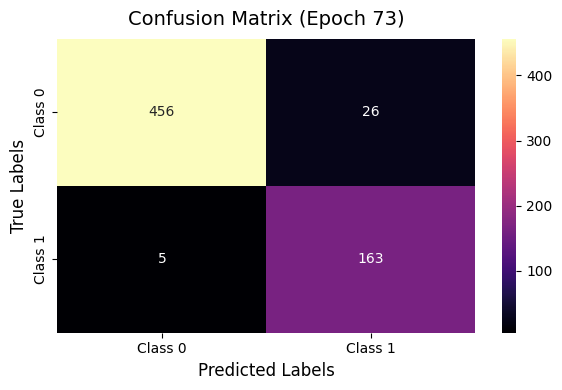

Epoch 73/100, Train Loss: 0.3645, Val Loss: 0.1373, Val Accuracy: 0.9523
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       482
           1       0.86      0.97      0.91       168

    accuracy                           0.95       650
   macro avg       0.93      0.96      0.94       650
weighted avg       0.96      0.95      0.95       650

ROC AUC Score: 0.9910


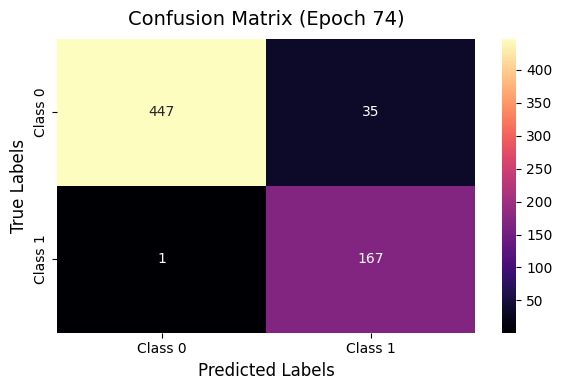

Epoch 74/100, Train Loss: 0.3686, Val Loss: 0.1459, Val Accuracy: 0.9446
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       482
           1       0.83      0.99      0.90       168

    accuracy                           0.94       650
   macro avg       0.91      0.96      0.93       650
weighted avg       0.95      0.94      0.95       650

ROC AUC Score: 0.9915


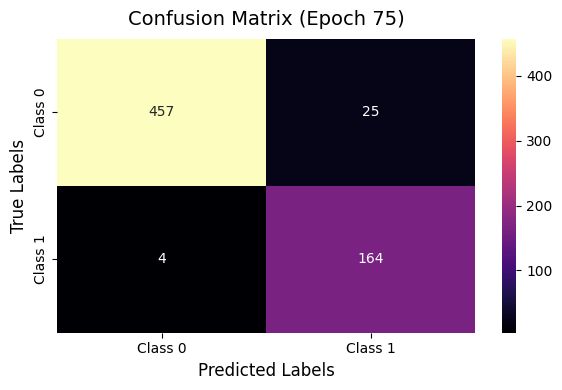

Epoch 75/100, Train Loss: 0.3264, Val Loss: 0.1290, Val Accuracy: 0.9554
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       482
           1       0.87      0.98      0.92       168

    accuracy                           0.96       650
   macro avg       0.93      0.96      0.94       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9917


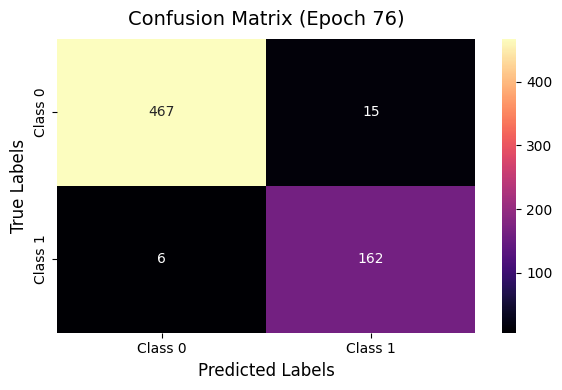

Epoch 76/100, Train Loss: 0.3442, Val Loss: 0.1197, Val Accuracy: 0.9677
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       482
           1       0.92      0.96      0.94       168

    accuracy                           0.97       650
   macro avg       0.95      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9924


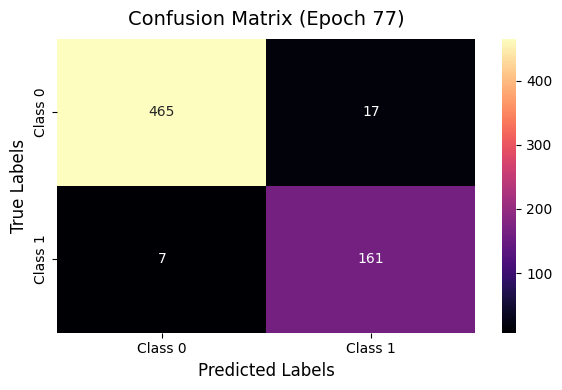

Epoch 77/100, Train Loss: 0.3277, Val Loss: 0.1154, Val Accuracy: 0.9631
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       482
           1       0.90      0.96      0.93       168

    accuracy                           0.96       650
   macro avg       0.94      0.96      0.95       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9934


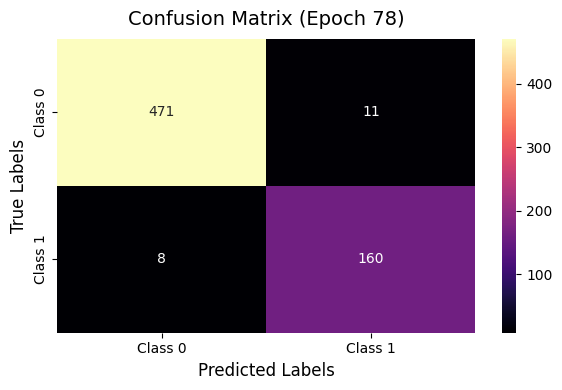

Epoch 78/100, Train Loss: 0.3258, Val Loss: 0.1211, Val Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       482
           1       0.94      0.95      0.94       168

    accuracy                           0.97       650
   macro avg       0.96      0.96      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9949


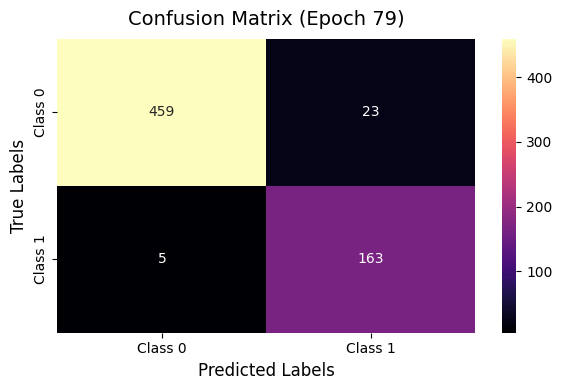

Epoch 79/100, Train Loss: 0.3062, Val Loss: 0.1097, Val Accuracy: 0.9569
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       482
           1       0.88      0.97      0.92       168

    accuracy                           0.96       650
   macro avg       0.93      0.96      0.95       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9938


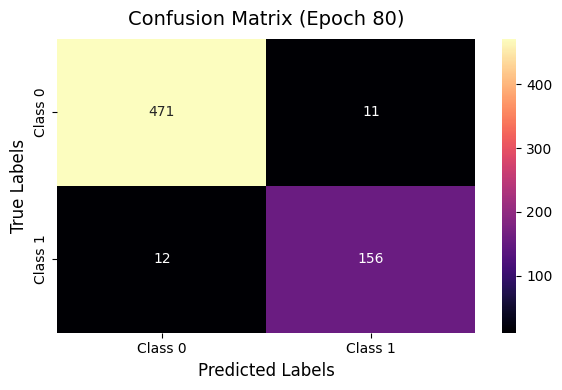

Epoch 80/100, Train Loss: 0.3394, Val Loss: 0.1234, Val Accuracy: 0.9646
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       482
           1       0.93      0.93      0.93       168

    accuracy                           0.96       650
   macro avg       0.95      0.95      0.95       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9949


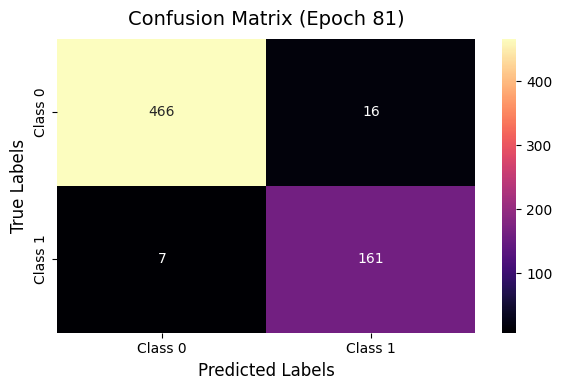

Epoch 81/100, Train Loss: 0.3344, Val Loss: 0.1152, Val Accuracy: 0.9646
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       482
           1       0.91      0.96      0.93       168

    accuracy                           0.96       650
   macro avg       0.95      0.96      0.95       650
weighted avg       0.97      0.96      0.96       650

ROC AUC Score: 0.9942


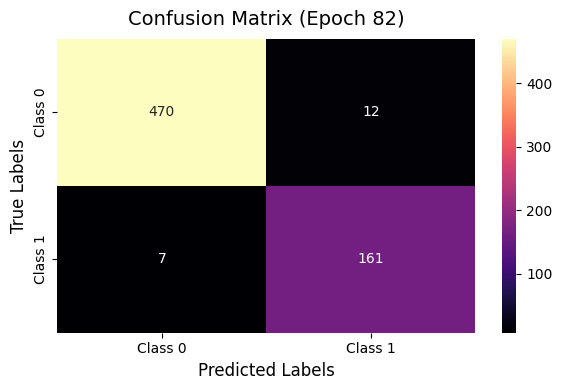

Epoch 82/100, Train Loss: 0.2869, Val Loss: 0.1059, Val Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       482
           1       0.93      0.96      0.94       168

    accuracy                           0.97       650
   macro avg       0.96      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9949


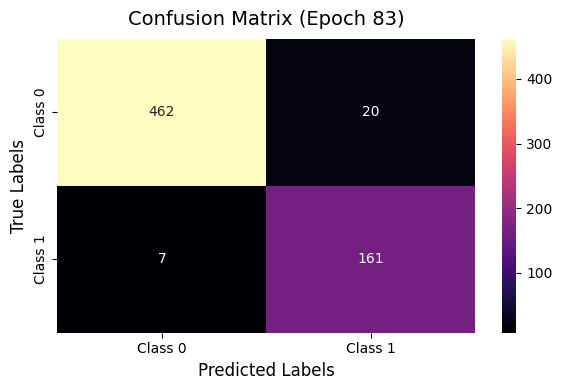

Epoch 83/100, Train Loss: 0.3332, Val Loss: 0.1118, Val Accuracy: 0.9585
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       482
           1       0.89      0.96      0.92       168

    accuracy                           0.96       650
   macro avg       0.94      0.96      0.95       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9935


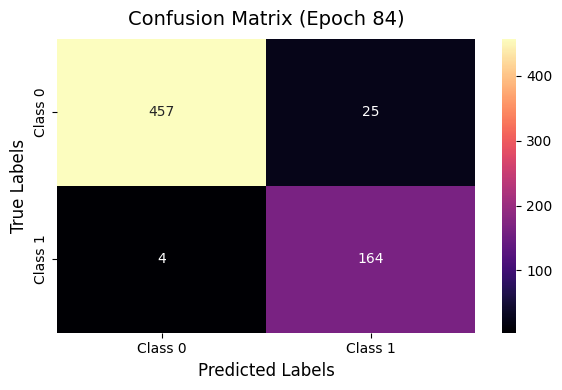

Epoch 84/100, Train Loss: 0.3053, Val Loss: 0.0947, Val Accuracy: 0.9554
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       482
           1       0.87      0.98      0.92       168

    accuracy                           0.96       650
   macro avg       0.93      0.96      0.94       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9951


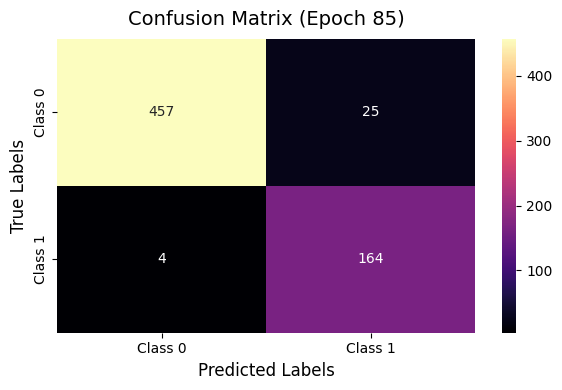

Epoch 85/100, Train Loss: 0.3387, Val Loss: 0.1113, Val Accuracy: 0.9554
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       482
           1       0.87      0.98      0.92       168

    accuracy                           0.96       650
   macro avg       0.93      0.96      0.94       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9935


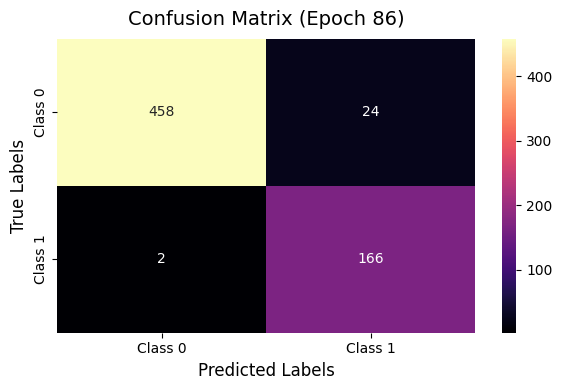

Epoch 86/100, Train Loss: 0.3386, Val Loss: 0.0933, Val Accuracy: 0.9600
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       482
           1       0.87      0.99      0.93       168

    accuracy                           0.96       650
   macro avg       0.93      0.97      0.95       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9968


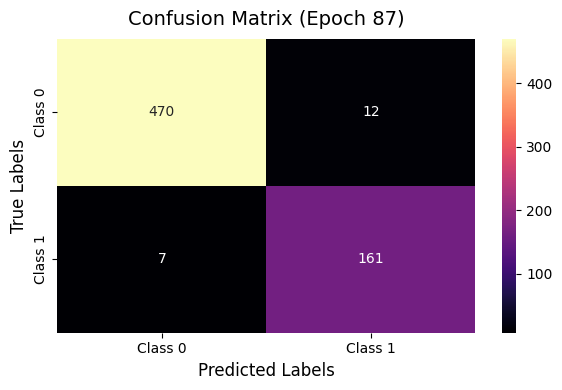

Epoch 87/100, Train Loss: 0.3054, Val Loss: 0.1059, Val Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       482
           1       0.93      0.96      0.94       168

    accuracy                           0.97       650
   macro avg       0.96      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9955


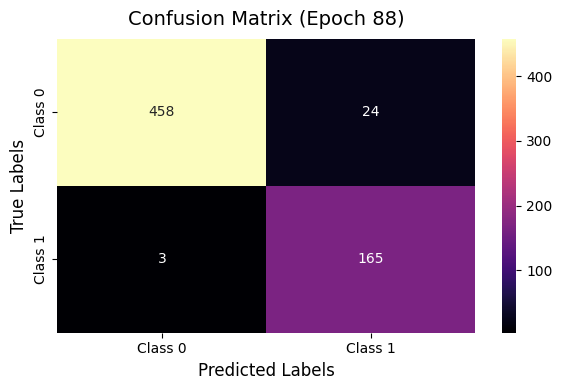

Epoch 88/100, Train Loss: 0.3274, Val Loss: 0.1017, Val Accuracy: 0.9585
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       482
           1       0.87      0.98      0.92       168

    accuracy                           0.96       650
   macro avg       0.93      0.97      0.95       650
weighted avg       0.96      0.96      0.96       650

ROC AUC Score: 0.9949


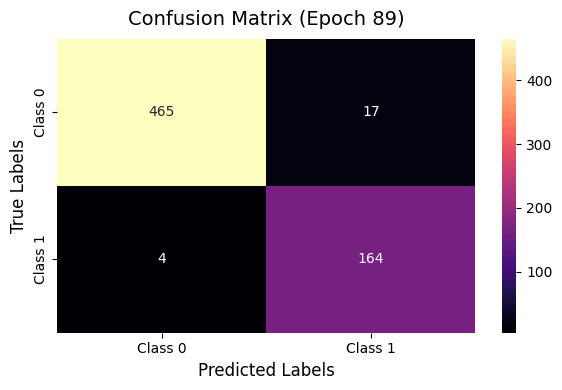

Epoch 89/100, Train Loss: 0.3260, Val Loss: 0.0965, Val Accuracy: 0.9677
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       482
           1       0.91      0.98      0.94       168

    accuracy                           0.97       650
   macro avg       0.95      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9969


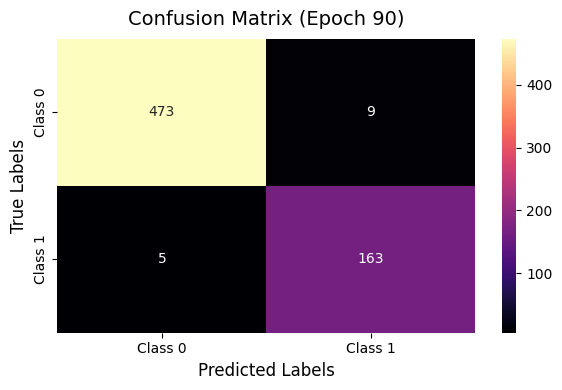

Epoch 90/100, Train Loss: 0.3242, Val Loss: 0.0993, Val Accuracy: 0.9785
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       482
           1       0.95      0.97      0.96       168

    accuracy                           0.98       650
   macro avg       0.97      0.98      0.97       650
weighted avg       0.98      0.98      0.98       650

ROC AUC Score: 0.9968


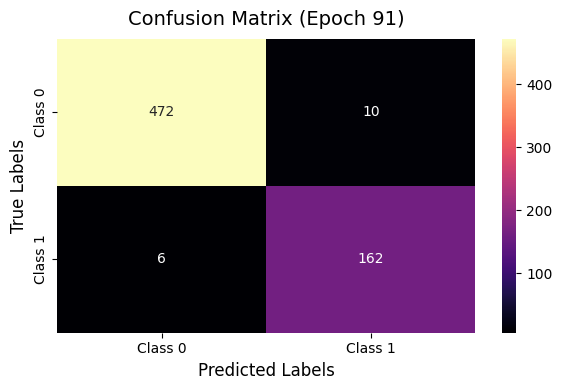

Epoch 91/100, Train Loss: 0.3411, Val Loss: 0.1005, Val Accuracy: 0.9754
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       482
           1       0.94      0.96      0.95       168

    accuracy                           0.98       650
   macro avg       0.96      0.97      0.97       650
weighted avg       0.98      0.98      0.98       650

ROC AUC Score: 0.9970


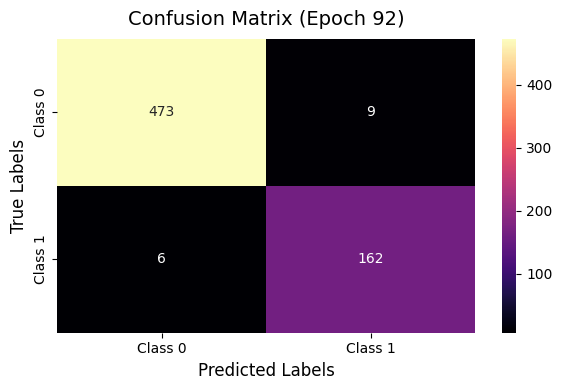

Epoch 92/100, Train Loss: 0.2982, Val Loss: 0.0915, Val Accuracy: 0.9769
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       482
           1       0.95      0.96      0.96       168

    accuracy                           0.98       650
   macro avg       0.97      0.97      0.97       650
weighted avg       0.98      0.98      0.98       650

ROC AUC Score: 0.9977


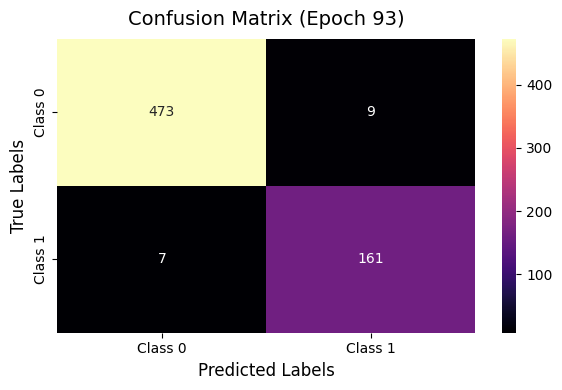

Epoch 93/100, Train Loss: 0.3217, Val Loss: 0.0861, Val Accuracy: 0.9754
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       482
           1       0.95      0.96      0.95       168

    accuracy                           0.98       650
   macro avg       0.97      0.97      0.97       650
weighted avg       0.98      0.98      0.98       650

ROC AUC Score: 0.9980


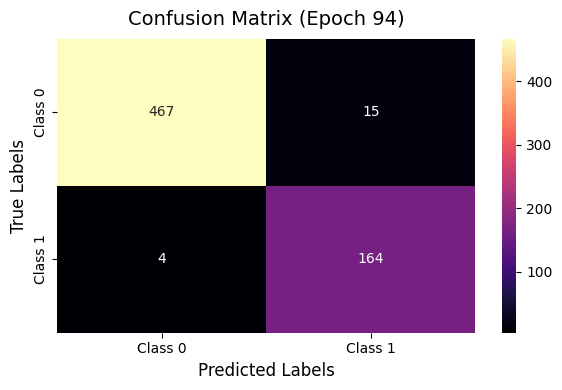

Epoch 94/100, Train Loss: 0.3303, Val Loss: 0.0994, Val Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       482
           1       0.92      0.98      0.95       168

    accuracy                           0.97       650
   macro avg       0.95      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9963


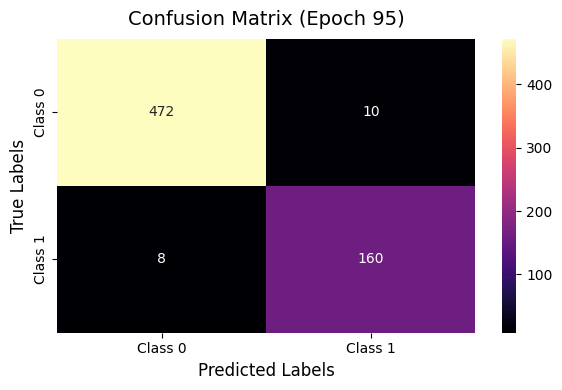

Epoch 95/100, Train Loss: 0.3459, Val Loss: 0.1127, Val Accuracy: 0.9723
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       482
           1       0.94      0.95      0.95       168

    accuracy                           0.97       650
   macro avg       0.96      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9941


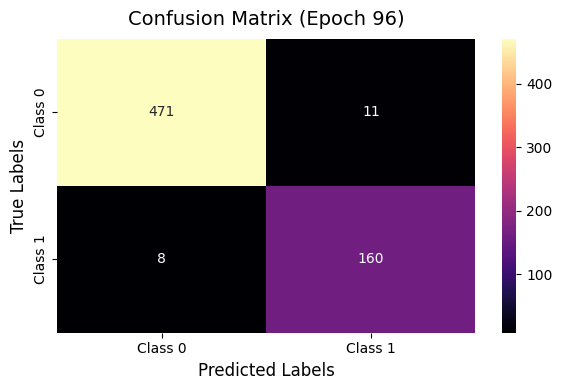

Epoch 96/100, Train Loss: 0.3071, Val Loss: 0.1044, Val Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       482
           1       0.94      0.95      0.94       168

    accuracy                           0.97       650
   macro avg       0.96      0.96      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9954


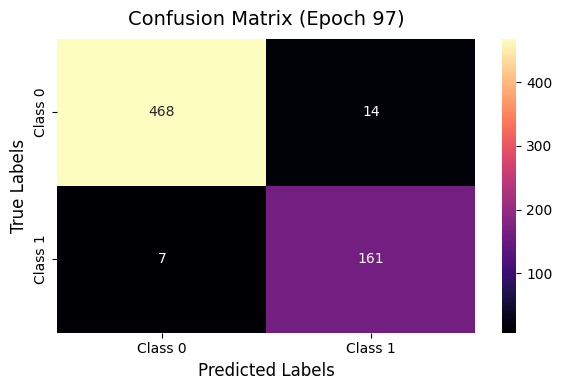

Epoch 97/100, Train Loss: 0.2875, Val Loss: 0.0931, Val Accuracy: 0.9677
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       482
           1       0.92      0.96      0.94       168

    accuracy                           0.97       650
   macro avg       0.95      0.96      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9968


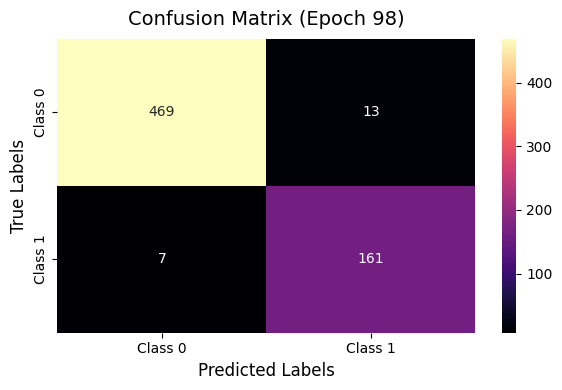

Epoch 98/100, Train Loss: 0.2942, Val Loss: 0.0944, Val Accuracy: 0.9692
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       482
           1       0.93      0.96      0.94       168

    accuracy                           0.97       650
   macro avg       0.96      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9958


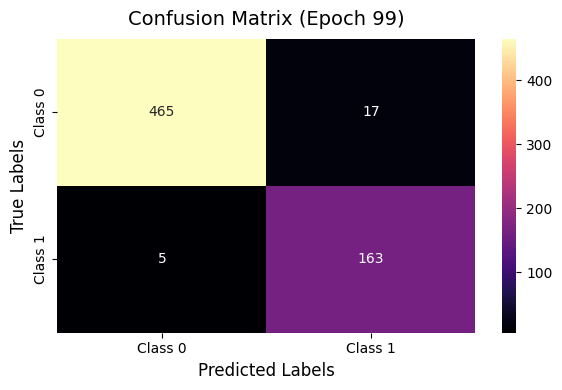

Epoch 99/100, Train Loss: 0.2865, Val Loss: 0.0781, Val Accuracy: 0.9662
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       482
           1       0.91      0.97      0.94       168

    accuracy                           0.97       650
   macro avg       0.95      0.97      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9977


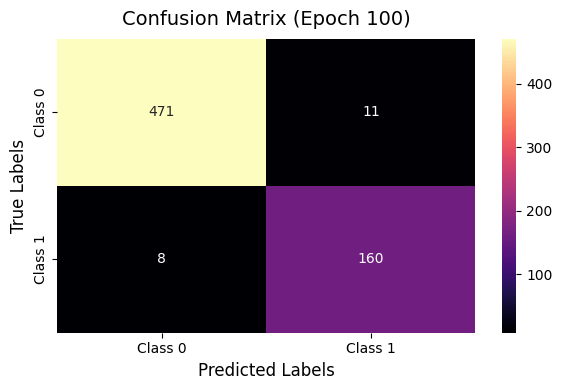

Epoch 100/100, Train Loss: 0.3320, Val Loss: 0.0927, Val Accuracy: 0.9708
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       482
           1       0.94      0.95      0.94       168

    accuracy                           0.97       650
   macro avg       0.96      0.96      0.96       650
weighted avg       0.97      0.97      0.97       650

ROC AUC Score: 0.9973


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your datasets and data loaders
train_dataset = GlaucomaDataset(df=labels_df, image_dir=image_dir, transform=train_transforms)
val_dataset = GlaucomaDataset(df=labels_df, image_dir=image_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)  # Adjust batch_size based on your GPU
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)    # Adjust batch_size based on your GPU

# Initialize the model, loss function, optimizer, and scheduler
model = MobileViTGlaucomaClassifier(num_classes=2).to(device)
model.unfreeze_last_layer()

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels_df['Label']),
                                     y=labels_df['Label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(trainable_params, lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training parameters
num_epochs = 100  # Adjust as needed

# Initialize lists to store loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, cdrs, labels in train_loader:
        images = images.to(device)
        cdrs = cdrs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images, cdrs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)  # Store training loss

    model.eval()
    val_loss = 0.0
    correct = 0
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for images, cdrs, labels in val_loader:
            images = images.to(device)
            cdrs = cdrs.to(device)
            labels = labels.to(device)

            outputs = model(images, cdrs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_accuracy = correct / len(val_dataset)

    # Plot confusion matrix with magma colormap
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=True,
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'], annot_kws={"size": 10})
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title(f'Confusion Matrix (Epoch {epoch+1})', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    try:
        auc = roc_auc_score(all_labels, all_probs)
        print(f"ROC AUC Score: {auc:.4f}")
    except ValueError:
        print("ROC AUC Score: Cannot be computed due to lack of positive or negative samples.")

    # Step the scheduler if you're using it
    scheduler.step()

# After training, plot the training and validation loss curves
plt.figure(figsize=(10, 6))
epochs_range = range(1, num_epochs + 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##save the model

In [ ]:
torch.save(model.state_dict(), "glaucoma_model.pth")
print("Model saved as glaucoma_model.pth")

Model saved as glaucoma_model.pth


In [ ]:
model = MobileViTGlaucomaClassifier(num_classes=2, pretrained=False)

model.load_state_dict(torch.load("glaucoma_model.pth"))
model.to(device)
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


<ipython-input-12-937014f0af83>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("glaucoma_model.pth"))


In [ ]:
labels_df

,Image_name,cdr,Label
0,001.jpg,0.7097,0
1,002.jpg,0.6953,0
2,003.jpg,0.9629,0
3,004.jpg,0.7246,0
4,005.jpg,0.6138,0
...,...,...,...
645,646.jpg,0.6560,1
646,647.jpg,0.7365,1
647,648.jpg,0.5101,1
648,649.jpg,0.5227,0


Predicted Class: 1
Class Probabilities: [[0.05019595 0.94980407]]


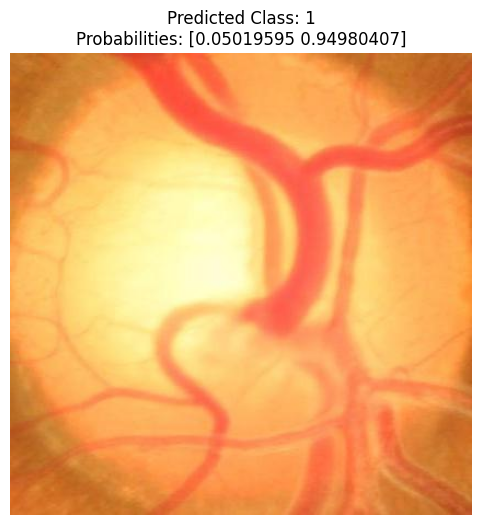

In [ ]:
which_one = 645

image_name = labels_df.iloc[which_one]['Image_name']
image_path = os.path.join(image_dir, image_name)


original_image = Image.open(image_path).convert('RGB')
image = np.array(original_image)
transformed = val_transforms(image=image)
image_tensor = transformed['image'].unsqueeze(0)
cdr_value = torch.tensor([labels_df.iloc[which_one]['cdr']], dtype=torch.float).to(device)

image_tensor = image_tensor.to(device)

with torch.no_grad():
    output = model(image_tensor, cdr_value)
    probs = torch.softmax(output, dim=1)
    _, predicted_class = torch.max(output, 1)

predicted_label = predicted_class.item()
class_probabilities = probs.cpu().numpy()

print(f"Predicted Class: {predicted_label}")
print(f"Class Probabilities: {class_probabilities}")

plt.figure(figsize=(6, 6))
plt.imshow(original_image)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_label}\n"
          f"Probabilities: {class_probabilities[0]}")
plt.show()
